# Exploritive analysis of heat generation

1. Heat generation of heat pump  
- For both heatpumps for which we measured we underestimate the heat generated by 3% and 7%  
- This underestimation is mostly driven by an underestimation of the flow rate. For both cases this consistently underestimates the flow by 5%.  
- Next step is to set up a measurement campaign to verify if this is the case for all flow meters.

2. Heat generation of Boiler
- For both heatpumps the heat generation of the boiler is underestimated by 10%  
- This difference comes mostly from underestimating the temperature difference. This could be explained by the heat loss between heatpump temperature outlet and the actual inlet temperature of the boiler.  
- The flowrate on the other hand is often over estimated. This could have to do with the 'internal' flow meter being connected after the by-pass whereas the external one is connected right after the boiler. This should influence the flowrates measured especially when the pump of the heatpump is running, but seems to also influence the flowrate when only the boiler is working.  
- Next step: -

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from quatt_aws_utils.s3 import create_s3_client
from datetime import datetime
import os

### Loading data from S3 of CSV

In [36]:
# read csv (alternative to loading data from S3)
path_live_data = os.path.join(os.path.split(os.getcwd())[0], 'data')
heat_df = pd.read_csv(os.path.join(path_live_data, 'heat_df.csv'))

In [21]:
heat_df['system.quattId'].value_counts()

CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6    862830
CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c    859794
Name: system.quattId, dtype: int64

### Comparing measurements for heat pump

Below graphs show that the difference between internal and externally measured heat generation is mainly caused by a difference in the flow meter. So a measurement campaign will be set up to get more insight into these differences.  

- Below graphs show internally measured heat generation is lower than what the external meter measures by 3.4% and 5.8%.
- Difference between internal and external increases during periods in which the heatpump is being used.

-0.03289623518491447


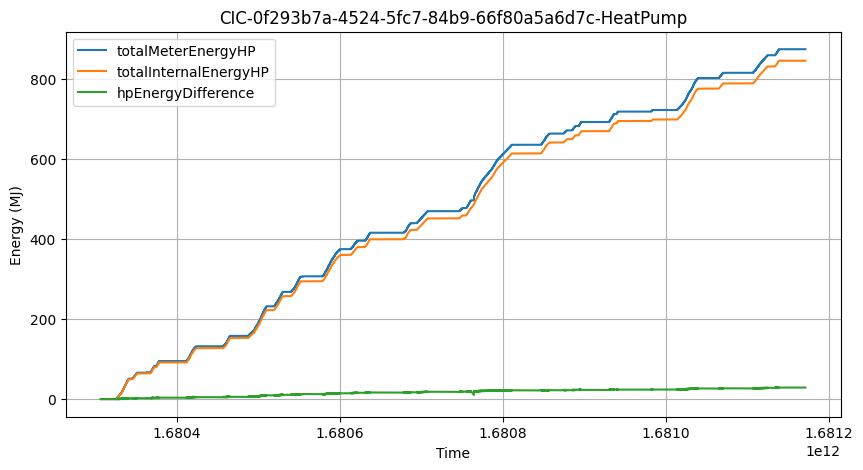

-0.07205018711597126


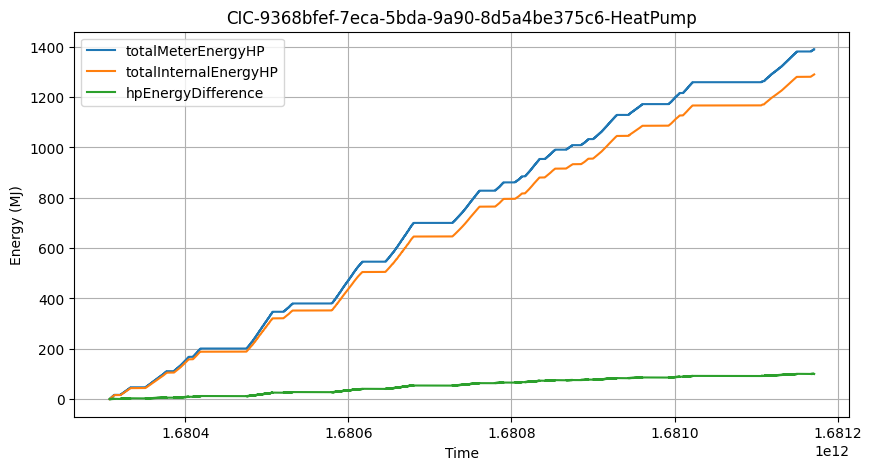

In [6]:
# plot energy
heat_df['totalMeterEnergyHP'] = heat_df.groupby('system.quattId', sort='time.ts', group_keys=False)['system.externalEnergyMeter1Energy'].apply(lambda x: x - x.iloc[0])
heat_df['totalMeterEnergyCV'] = heat_df.groupby('system.quattId', sort='time.ts', group_keys=False)['system.externalEnergyMeter2Energy'].apply(lambda x: x - x.iloc[0])
heat_df['totalInternalEnergyCV'] = heat_df.groupby('system.quattId', sort='time.ts', group_keys=False)['qc.cvEnergyCounter'].apply(lambda x: (x - x.iloc[0])/1000 * 3.6)
heat_df['totalInternalEnergyHP'] = heat_df.groupby('system.quattId', sort='time.ts', group_keys=False)['qc.hp1ThermalEnergyCounter'].apply(lambda x: (x - x.iloc[0])/1000 * 3.6)

heat_df['hpEnergyDifference'] =  heat_df['totalMeterEnergyHP'] - heat_df['totalInternalEnergyHP']

for key, grp in heat_df.groupby('system.quattId'):
    print((grp['totalInternalEnergyHP'].iloc[-1]-grp['totalMeterEnergyHP'].iloc[-1])/(grp['totalMeterEnergyHP'].iloc[-1]))
    grp[['time.ts','totalMeterEnergyHP','totalInternalEnergyHP','hpEnergyDifference']].plot(x='time.ts', figsize=(10,5), 
                                                                    title=f'{key}-HeatPump')
    plt.ylabel('Energy (MJ)')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

    

When we look at the difference in power during 'supervisoryControlMode = 2' we notice that the externally measured mean of the power is higher than the internally measured one.  
The external power units are only measured at certain moments in time, so we are only measuring difference for those moments.

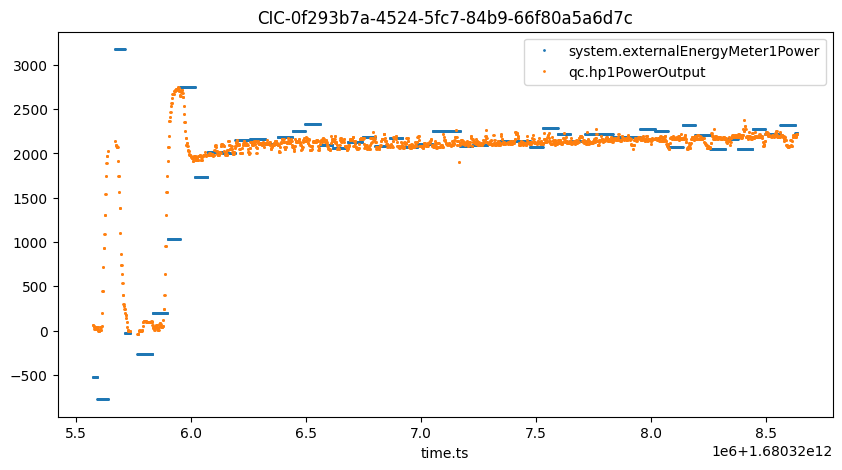

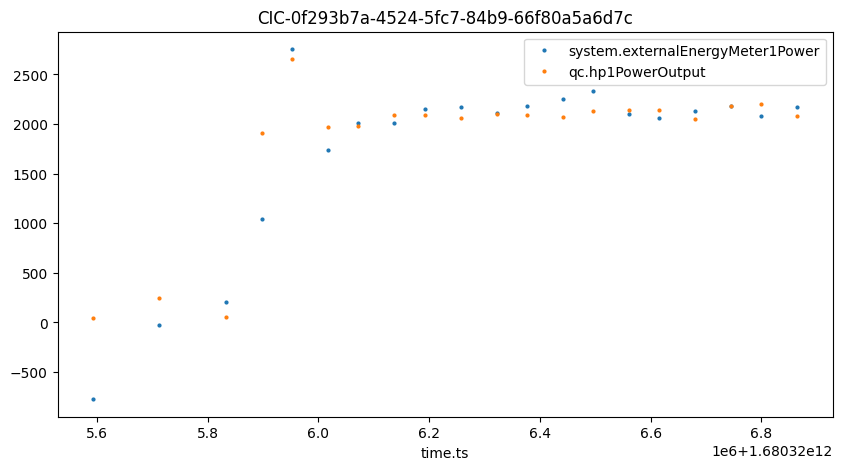

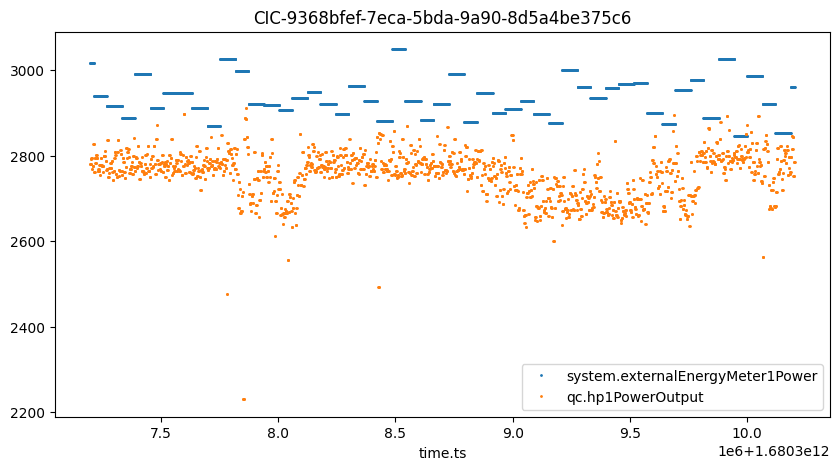

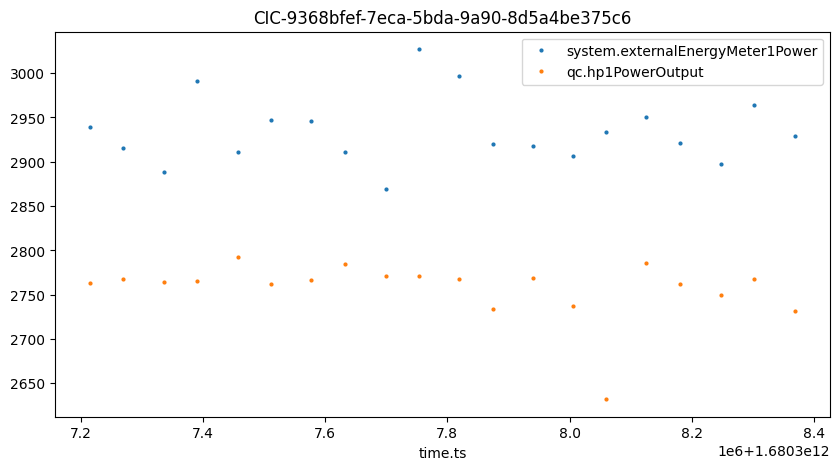

In [7]:
# find time steps where power is changing
heat_df['system.externalEnergyMeter1PowerDiff'] = heat_df.groupby('system.quattId', sort='time.ts', group_keys=False)['system.externalEnergyMeter1Power'].diff()


# zooming in to check how much the data has been shifted
for key, grp in heat_df.groupby('system.quattId'):
        grp[grp['qc.supervisoryControlMode']==2].sort_values(['time.ts'])[['time.ts',
                                                                           'system.externalEnergyMeter1Power',
                                                                           'qc.hp1PowerOutput']][0:3000].plot(x='time.ts', # 5000:5500
                                                                                                                 style='o',
                                                                                                            figsize=(10,5),
                                                                                                            title=key,
                                                                                                            markersize=1)
        plt.show()
        grp[(grp['qc.supervisoryControlMode']==2) & 
            (grp['system.externalEnergyMeter1PowerDiff'].abs()>0)].sort_values(['time.ts'])[['time.ts',
                                                                           'system.externalEnergyMeter1Power',
                                                                           'qc.hp1PowerOutput']][:20].plot(x='time.ts',
                                                                                                            figsize=(10,5),
                                                                                                            style='o',
                                                                                                            title=key,
                                                                                                            markersize=2)
        plt.show()
        


Power External - Internal:  56.27520468133707 [W]


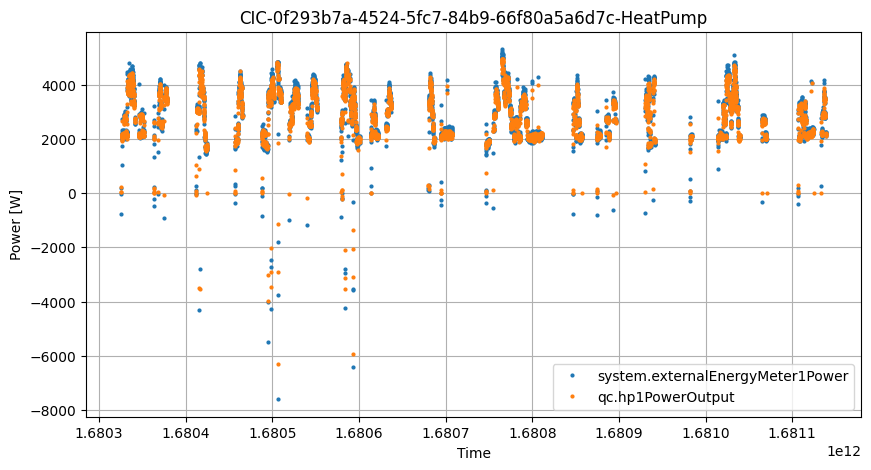

Power External - Internal:  209.01491353083156 [W]


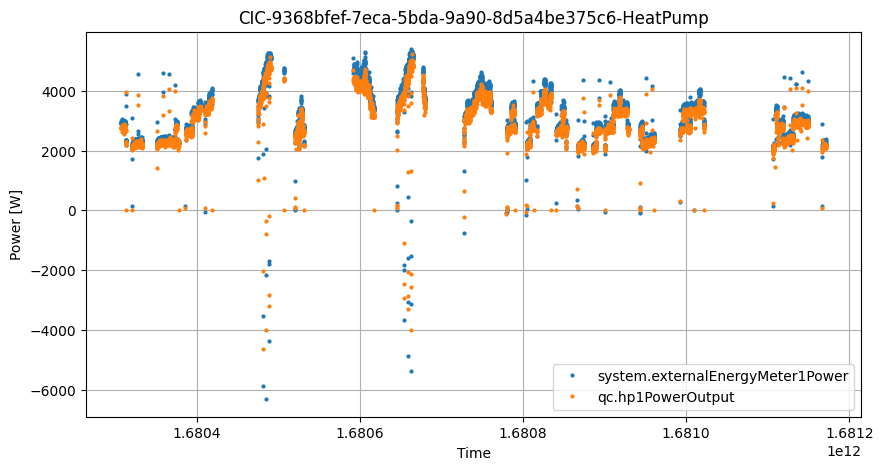

In [8]:
# plotting external and internal power
for key, grp in heat_df.groupby('system.quattId'):
    print('Power External - Internal: ', grp[(grp['qc.supervisoryControlMode']==2) & 
                                             (grp['system.externalEnergyMeter1PowerDiff'].abs()>0)]['system.externalEnergyMeter1Power'].mean() 
                                             - grp[(grp['qc.supervisoryControlMode']==2) & 
                                                   (grp['system.externalEnergyMeter1PowerDiff'].abs()>0)]['qc.hp1PowerOutput'].mean(), '[W]')
    grp[(grp['qc.supervisoryControlMode']==2) & 
        (grp['system.externalEnergyMeter1PowerDiff'].abs()>0)][['time.ts',
                                                                'system.externalEnergyMeter1Power',
                                                                'qc.hp1PowerOutput']].plot(x='time.ts', 
                                                                                           figsize=(10,5), 
                                                                                           title=f'{key}-HeatPump',
                                                                                           style='o',markersize=2)
    plt.ylabel('Power [W]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

The mean of the errors in % is 3.1% and 5.9%

mean error:  56.1824876832232 [W]


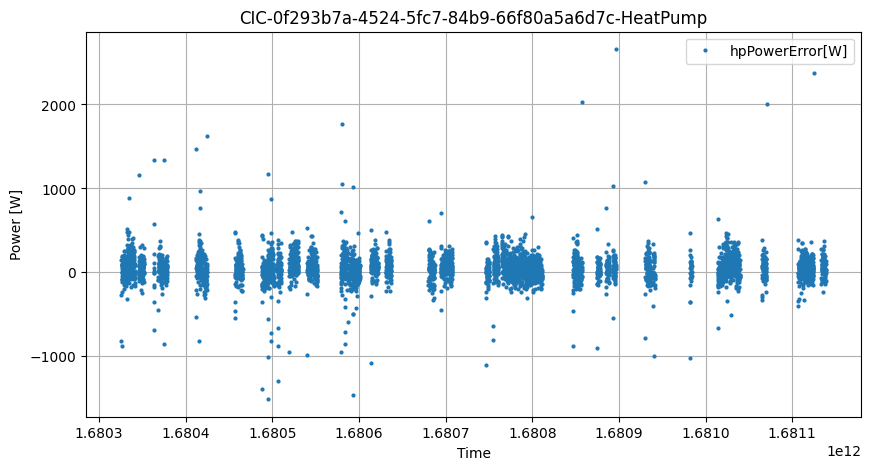

mean error:  3.0504998093280298 [%]


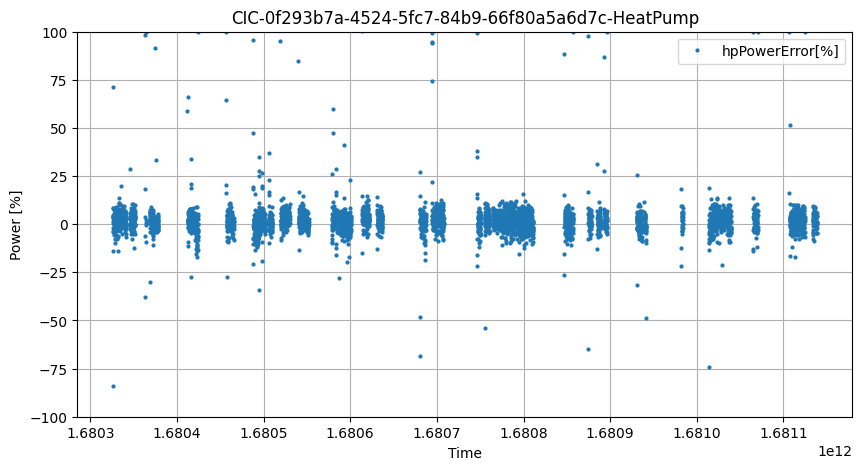

mean error:  209.157851516511 [W]


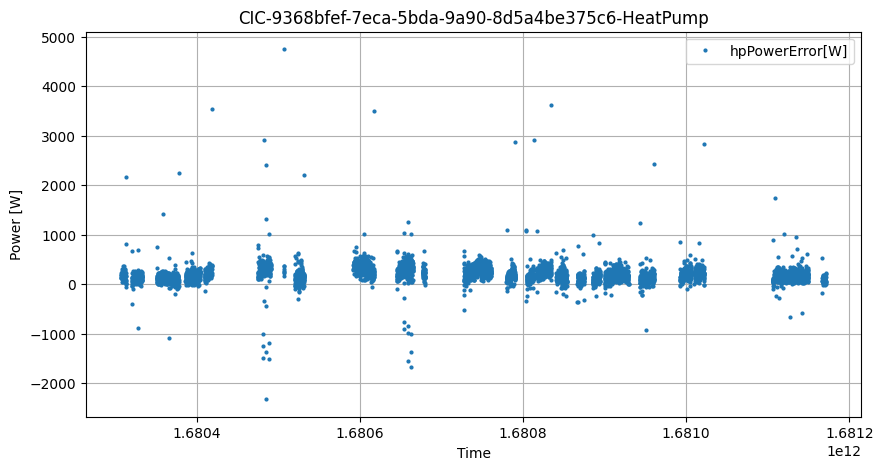

mean error:  inf [%]


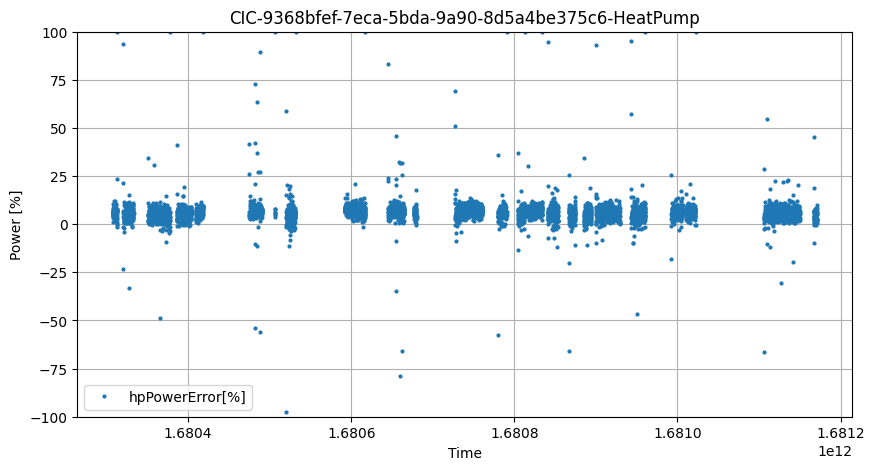

In [9]:
# plotting external and internal power
heat_df['hpPowerError[W]'] = heat_df['system.externalEnergyMeter1Power'] - heat_df['qc.hp1PowerOutput']
heat_df['hpPowerError[%]'] = (heat_df['system.externalEnergyMeter1Power'] - heat_df['qc.hp1PowerOutput']) / heat_df['system.externalEnergyMeter1Power'] * 100

for key, grp in heat_df.groupby('system.quattId'):
    print('mean error: ', grp[(grp['qc.supervisoryControlMode']==2) &
                              (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)]['hpPowerError[W]'].mean(), '[W]')
    
    # print and plot absolute difference in power
    grp[(grp['qc.supervisoryControlMode']==2) & 
        (grp['system.externalEnergyMeter1PowerDiff'].abs()>0)][['time.ts','hpPowerError[W]']].plot(x='time.ts',
                                                                                                   figsize=(10,5),
                                                                                                   title=f'{key}-HeatPump',
                                                                                                   style='o',markersize=2)
    plt.ylabel('Power [W]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()
    
    # print and plot relative error
    print('mean error: ', grp[(grp['qc.supervisoryControlMode']==2) &
                              (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)]['hpPowerError[%]'].mean(), '[%]')
    grp[(grp['qc.supervisoryControlMode']==2) & 
        (grp['system.externalEnergyMeter1PowerDiff'].abs()>0)][['time.ts','hpPowerError[%]']].plot(x='time.ts', 
                                                                                                   figsize=(10,5), 
                                                                                                   title=f'{key}-HeatPump',
                                                                                                   style='o',markersize=2)
    plt.ylabel('Power [%]')
    plt.xlabel('Time')
    plt.grid()
    plt.ylim([-100,100])
    plt.show()

Checking if this error is coming from a difference in Delta Temperature or from flowMeter.  
P [W] = DT [K] * FlowRate [l/hr] / 3600 * water_density * caloric_value  
P [W] = DT [K] * FlowRate [l/hr] / 3600 * 997 * 4.186 = DT * FlowRate * 1.159  
water_density = 997 # kg/m3  
caloric_value_water = 4.186 # kJ/kgK  
  
The plots below show an error of more than 5% for both flowmeters internally and externally, which is 2-3 times as large as the error on the temperature difference.  

For cic:  CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c
mean flowRate error :  4.790274528167853 [%]
median flowRate error :  4.827717556346387 [%]
mean temperature difference error :  -2.108621972973656 [%]
median temperature difference error :  -2.95459901008557 [%]


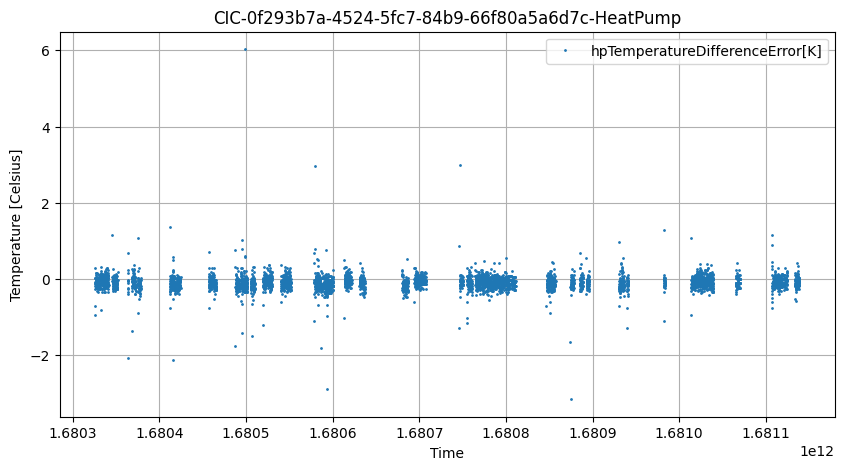

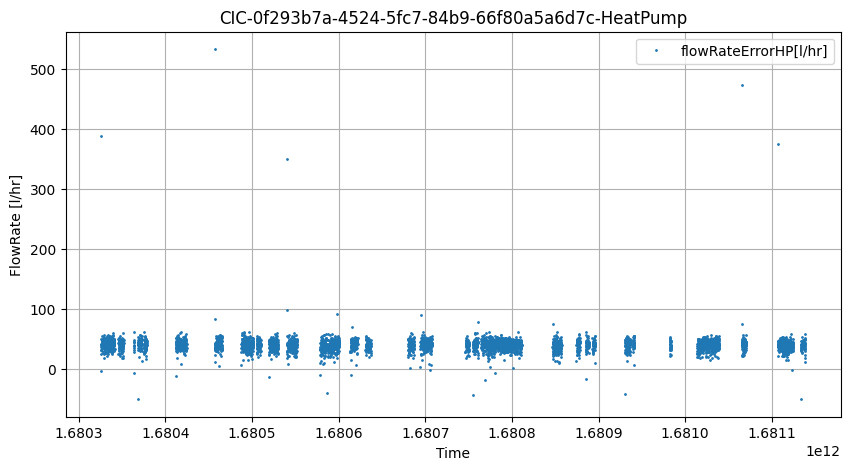

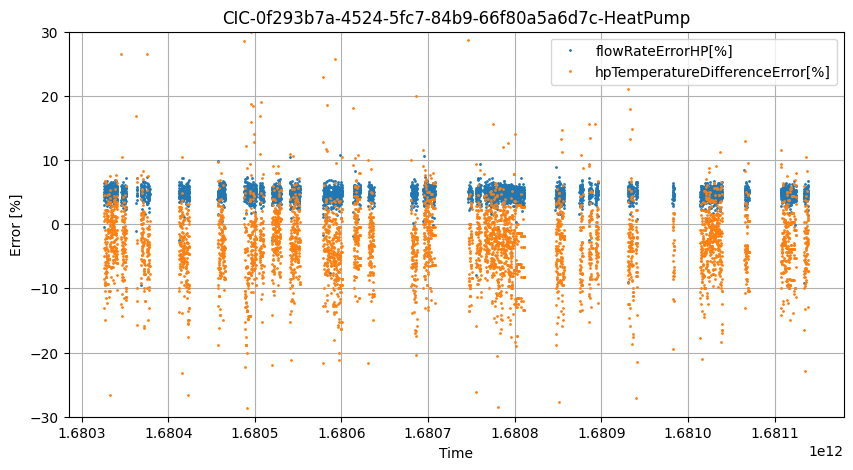

For cic:  CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6
mean flowRate error :  5.575157694115452 [%]
median flowRate error :  5.620898522483606 [%]
mean temperature difference error :  -0.71872367383058 [%]
median temperature difference error :  0.43483214925730235 [%]


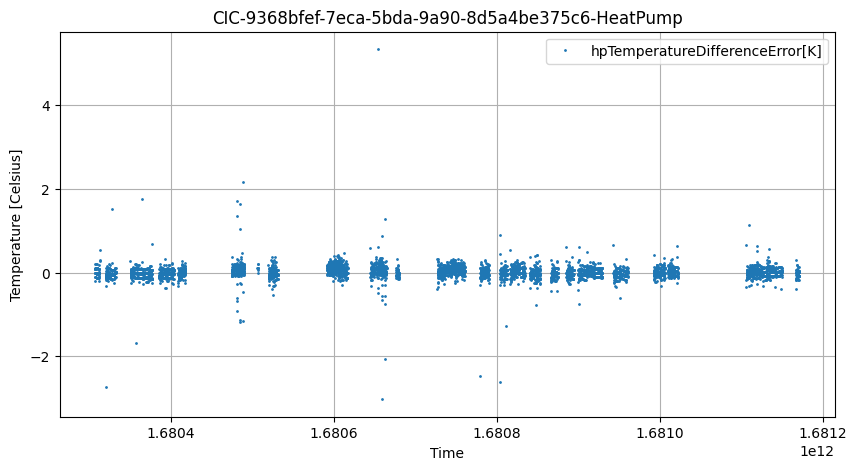

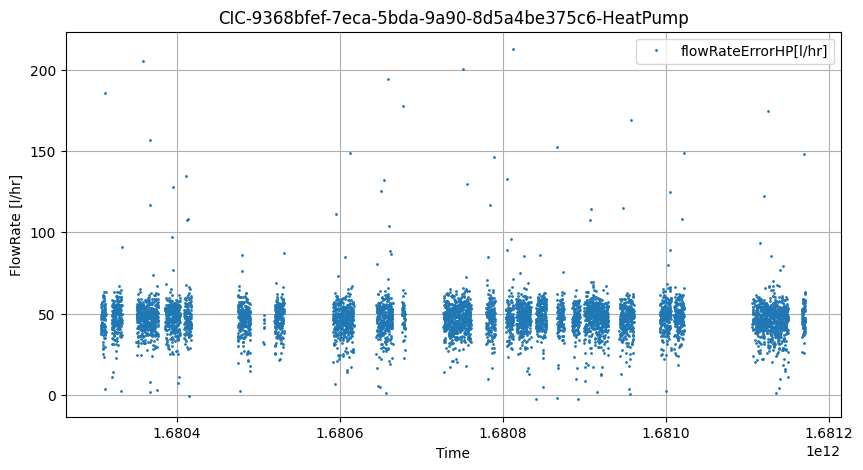

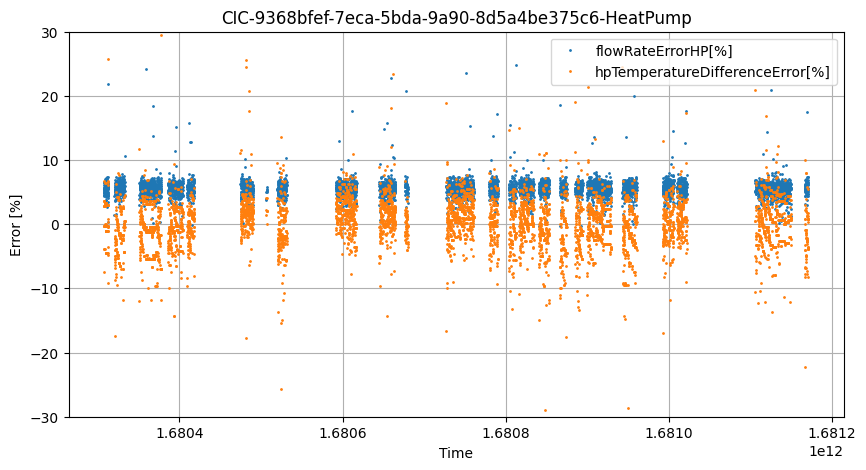

In [10]:
water_density = 997 # kg/m3
caloric_value_water = 4.186 # kJ/kgK

heat_df['flowRateErrorHP[l/hr]'] = heat_df['system.externalEnergyMeter1Flow'] - heat_df['flowMeter.flowRate']
heat_df['flowRateErrorHP[%]'] = heat_df['flowRateErrorHP[l/hr]'] / heat_df['system.externalEnergyMeter1Flow'] * 100

heat_df['hpTemperatureDifferenceInternal'] = heat_df['hp1.temperatureWaterOut'] - heat_df['hp1.temperatureWaterIn']
heat_df['hpTemperatureDifferenceExternal'] = heat_df['system.externalEnergyMeter1Supply'] - heat_df['system.externalEnergyMeter1Return']
heat_df['hpTemperatureDifferenceError[K]'] = heat_df['hpTemperatureDifferenceExternal'] - heat_df['hpTemperatureDifferenceInternal']
heat_df['hpTemperatureDifferenceError[%]'] = heat_df['hpTemperatureDifferenceError[K]'] / heat_df['hpTemperatureDifferenceExternal'] * 100

for key, grp in heat_df.groupby('system.quattId'):
    print('For cic: ', key)
    print('mean flowRate error : ', grp[(grp['qc.supervisoryControlMode']==2) & 
                                        (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)]['flowRateErrorHP[%]'].mean(), '[%]')
    print('median flowRate error : ', grp[(grp['qc.supervisoryControlMode']==2) & 
                                          (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)]['flowRateErrorHP[%]'].median(), '[%]')

    print('mean temperature difference error : ', grp[(grp['qc.supervisoryControlMode']==2) & 
                                                      (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)]['hpTemperatureDifferenceError[%]'].replace([np.inf, -np.inf], np.nan).mean(), '[%]')
    print('median temperature difference error : ', grp[(grp['qc.supervisoryControlMode']==2) & 
                                                        (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)]['hpTemperatureDifferenceError[%]'].replace([np.inf, -np.inf], np.nan).median(), '[%]')
    
    # plot absolute temperature error
    grp[(grp['qc.supervisoryControlMode']==2) & 
        (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)][['time.ts','hpTemperatureDifferenceError[K]']].plot(x='time.ts',
                                                                                                                   figsize=(10,5),
                                                                                                                   title=f'{key}-HeatPump',
                                                                                                                   style='o',markersize=1)
    plt.ylabel('Temperature [Celsius]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

    # plot absolute flowrate error
    grp[(grp['qc.supervisoryControlMode']==2) & 
        (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)][['time.ts','flowRateErrorHP[l/hr]']].plot(x='time.ts',
                                                                                                         figsize=(10,5),
                                                                                                         title=f'{key}-HeatPump',
                                                                                                         style='o',markersize=1)
    plt.ylabel('FlowRate [l/hr]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

    # plot relative errors
    grp[(grp['qc.supervisoryControlMode']==2) & 
        (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)][['time.ts','flowRateErrorHP[%]', 'hpTemperatureDifferenceError[%]']].plot(x='time.ts',
                                                                                                                                         figsize=(10,5),
                                                                                                                                         title=f'{key}-HeatPump',
                                                                                                                                         style='o',markersize=1)
    plt.ylabel('Error [%]')
    plt.xlabel('Time')
    plt.ylim(-30,30)
    plt.grid()
    plt.show()

The flowrate error on average is 40-50 l/hr.  
The internal meter has an accuracy of up to  l/30hr.  
The external meter has an accuracy of up to 16 l/hr. (@flowrate of 800l/hr)  

These two inaccuracies could explain the gap between the flowmeters. It is not clear whether the mentioned accuracies are accuracies in variance, or if it could also be a bias which is constantly present.  

More measurements of the flow meter could help estimate whether we see the same under estimation of flow and if we have to compensate for that.

Look at how the external meters are mounted, product drive, suppliers, includes a picture how it should be mounted. This could cause a difference in the measurements.
> flow meters from Bas
> Check if we are complying wit the correct way of installation
> Check with Kevin how we can improve installation of our reference meter in the testing position
> Check if we can find a more accurate version of the flow meter > get in touch with contact of Kevin at (Sharky)
> make sure 'own' flowmeter is installed how its typically installed at the client

### Comparing measurements for CV

Below graphs show a difference in heat generated by the CV.  
Where the external energy meter estimates a way higher energy than the internal one.

To do: 
- Internal generated heat counter goes down because of negative power generation values. We could change the counter such that this value only increases over time. Additionally we can add a 'cooling counter' to keep track of when we cool down the house.
[ ] Check if difference comes from flowmeter of from temperature

-0.32871661589213463


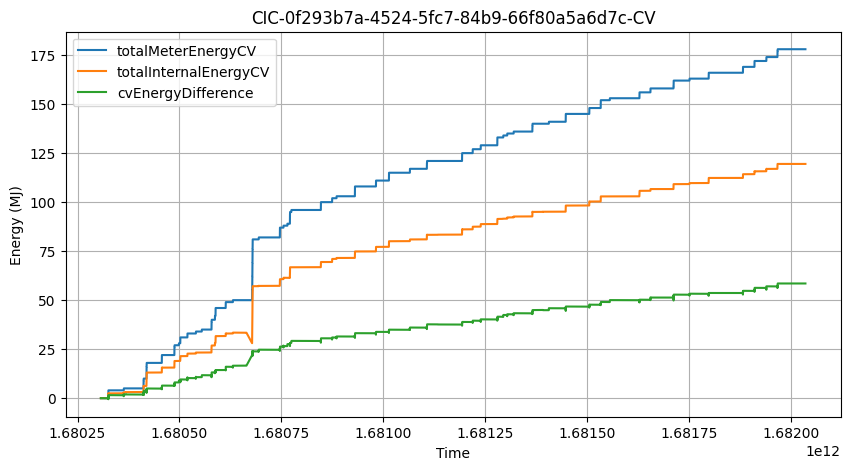

-0.4455106811428571


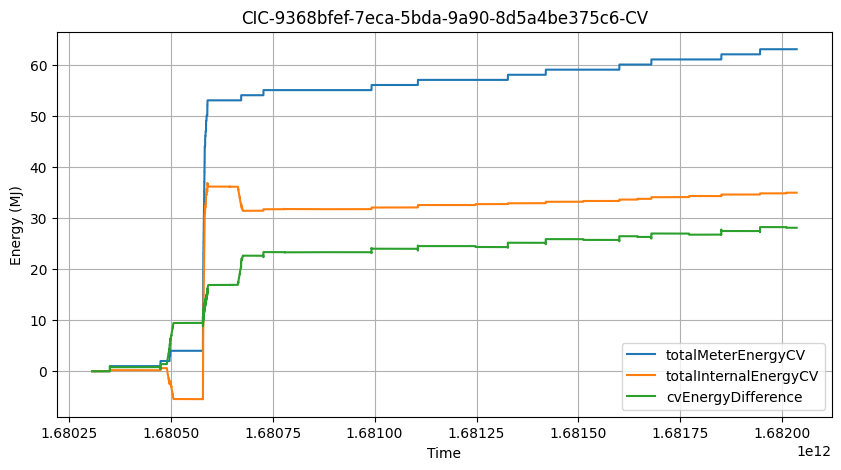

In [37]:
heat_df.sort_values(['system.quattId', 'time.ts'], inplace=True)
# plot energy for cv
heat_df['totalMeterEnergyCV'] = heat_df.groupby('system.quattId', sort='time.ts', group_keys=False)['system.externalEnergyMeter2Energy'].apply(lambda x: x - x.iloc[0])
heat_df['totalInternalEnergyCV'] = heat_df.groupby('system.quattId', sort='time.ts', group_keys=False)['qc.cvEnergyCounter'].apply(lambda x: (x - x.iloc[0])/1000 * 3.6)

heat_df['cvEnergyDifference'] =  heat_df['totalMeterEnergyCV'] - heat_df['totalInternalEnergyCV']

for key, grp in heat_df.groupby('system.quattId'):
    print((grp['totalInternalEnergyCV'].iloc[-1]-grp['totalMeterEnergyCV'].iloc[-1])/(grp['totalMeterEnergyCV'].iloc[-1]))
    grp[['time.ts','totalMeterEnergyCV','totalInternalEnergyCV','cvEnergyDifference']].plot(x='time.ts', figsize=(10,5), 
                                                                    title=f'{key}-CV')
    plt.ylabel('Energy (MJ)')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

-0.944952642285244


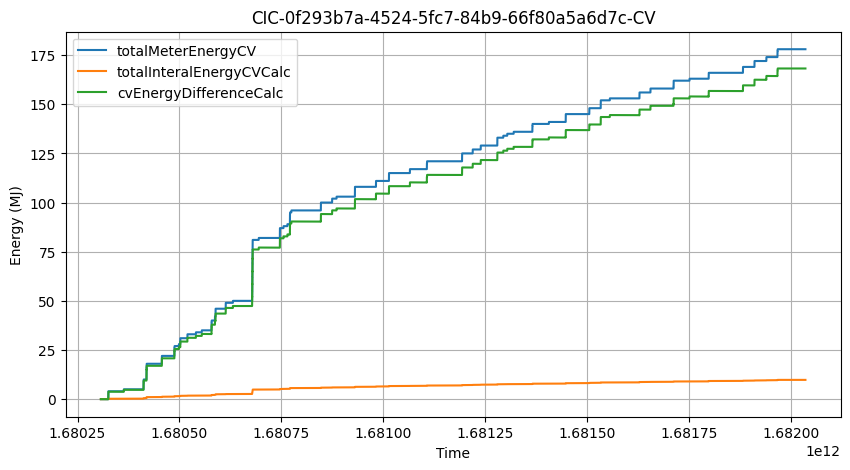

-0.9379470427382335


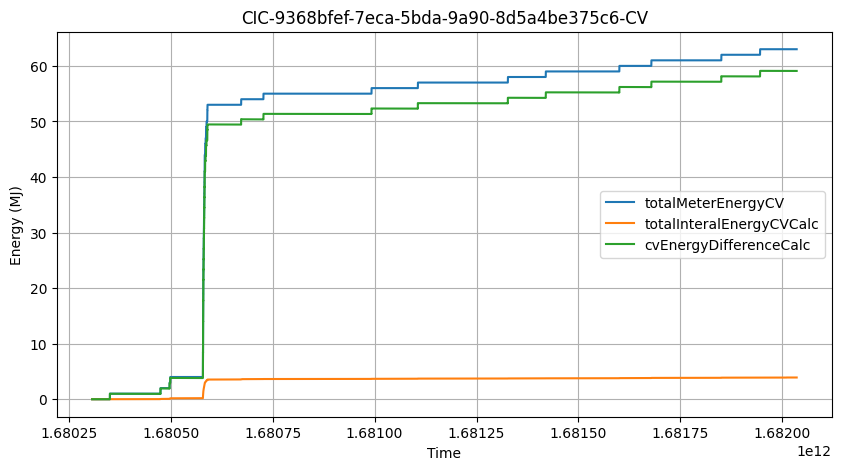

In [38]:
# calculate heat energy generated by CV based on integrating positive power values only
heat_df['timediff[s]'] = heat_df.groupby('system.quattId', sort='time.ts')['time.ts'].diff()/1000
heat_df['cvEnergyCalc[kWh]'] = heat_df['qc.cvPowerOutput'].apply(lambda x: x if x>0 else 0) * heat_df['timediff[s]'] /(3600)
heat_df['cvEnergyCalc[MJ]'] = heat_df['cvEnergyCalc[kWh]'] / 3600
heat_df['totalInteralEnergyCVCalc'] = heat_df.groupby('system.quattId', sort='time.ts')['cvEnergyCalc[MJ]'].cumsum()
heat_df['cvEnergyDifferenceCalc'] =  heat_df['totalMeterEnergyCV'] - heat_df['totalInteralEnergyCVCalc']

# plot new calculated internal cv energy value
for key, grp in heat_df.groupby('system.quattId'):
    print((grp['totalInteralEnergyCVCalc'].iloc[-1]-grp['totalMeterEnergyCV'].iloc[-1])/(grp['totalMeterEnergyCV'].iloc[-1]))
    grp[['time.ts','totalMeterEnergyCV','totalInteralEnergyCVCalc','cvEnergyDifferenceCalc']].plot(x='time.ts', figsize=(10,5), 
                                                                    title=f'{key}-CV')
    plt.ylabel('Energy (MJ)')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

In this short timeframe the differences between internal and external are multiple thousands on average.

Power External - Internal:  1462.833583273312 [W]


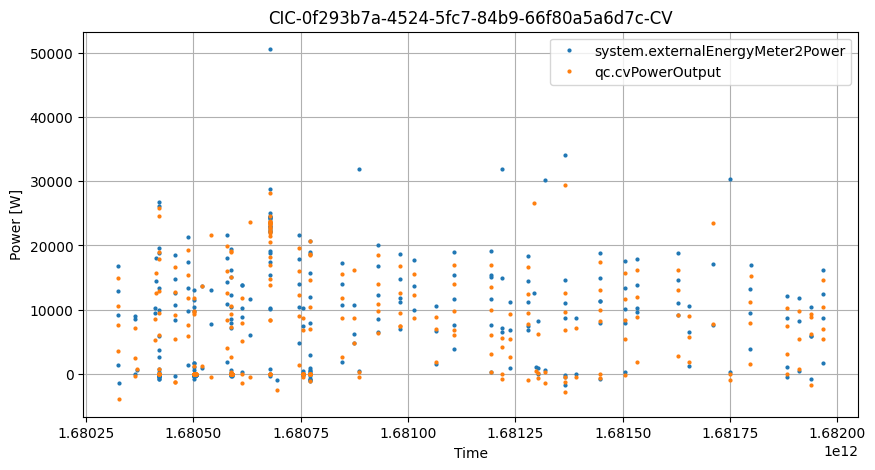

Power External - Internal:  604.2536954140508 [W]


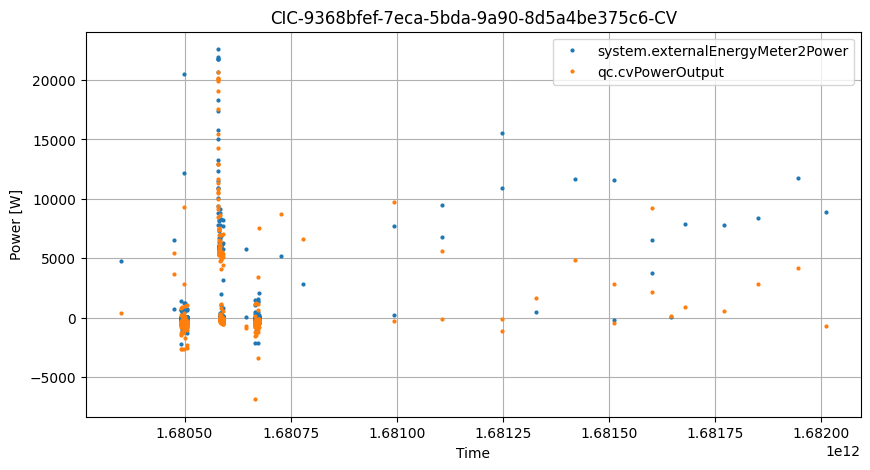

In [39]:
# find time steps where power is changing
heat_df['system.externalEnergyMeter2PowerDiff'] = heat_df.groupby('system.quattId', sort='time.ts', group_keys=False)['system.externalEnergyMeter2Power'].diff()


# plotting external and internal power
for key, grp in heat_df.groupby('system.quattId', sort='time.ts'):
    print('Power External - Internal: ', grp[((grp['qc.supervisoryControlMode']==3) | (grp['qc.supervisoryControlMode']==4)) & 
                                             (grp['system.externalEnergyMeter2PowerDiff'].abs()>0)]['system.externalEnergyMeter2Power'].mean() 
                                             - grp[((grp['qc.supervisoryControlMode']==3) | (grp['qc.supervisoryControlMode']==4)) & 
                                                   (grp['system.externalEnergyMeter2PowerDiff'].abs()>0)]['qc.cvPowerOutput'].mean(), '[W]')
    grp[((grp['qc.supervisoryControlMode']==3) | (grp['qc.supervisoryControlMode']==4)) & 
        (grp['system.externalEnergyMeter2PowerDiff'].abs()>0)][['time.ts',
                                                                'system.externalEnergyMeter2Power',
                                                                'qc.cvPowerOutput']].plot(x='time.ts', 
                                                                                           figsize=(10,5), 
                                                                                           title=f'{key}-CV',
                                                                                           style='o',markersize=2)
    plt.ylabel('Power [W]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

We plot the absolute and relative errors of the power of the boiler.

mean error:  1385.5716928290321 [W]


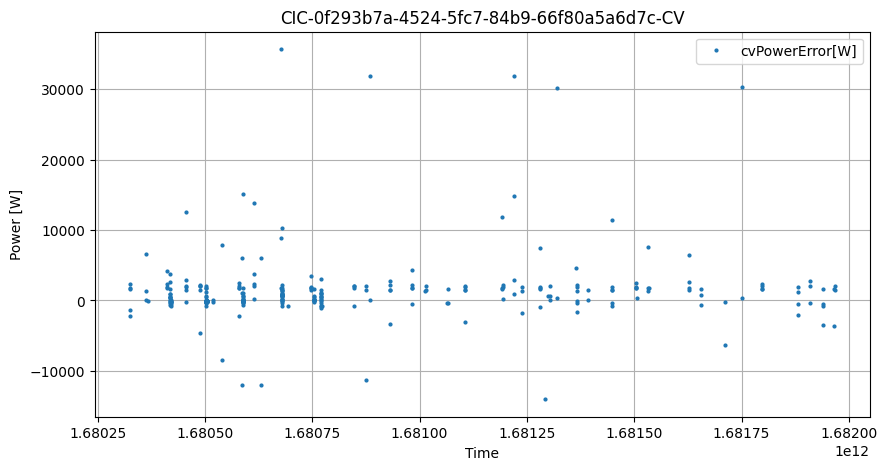

mean error:  42.70243963802062 [%]


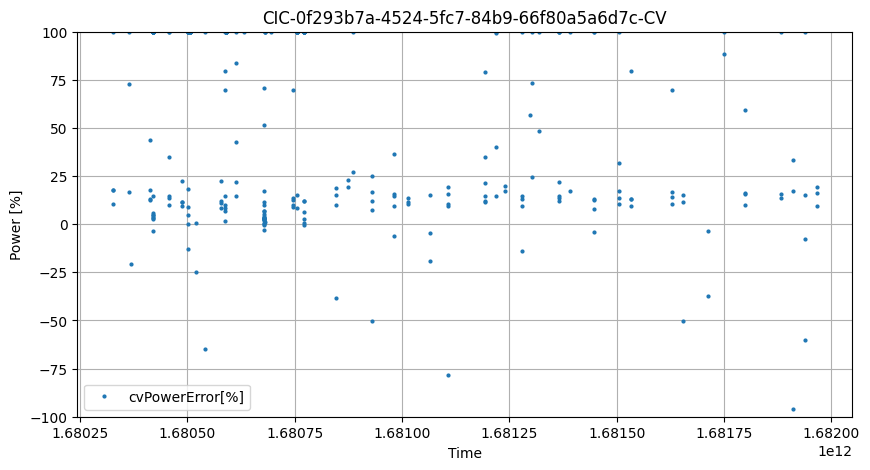

mean error:  233.7693987522659 [W]


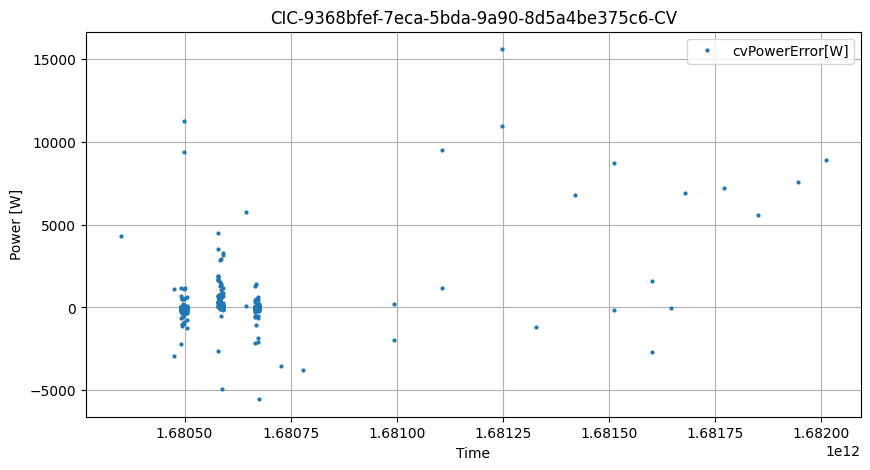

mean error:  79.03577174174028 [%]


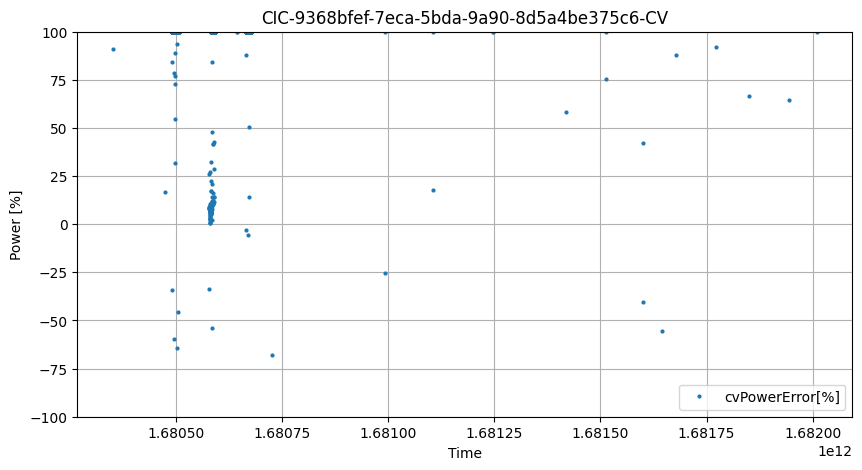

In [40]:
# plotting external and internal powererros
heat_df['cvPowerError[W]'] = heat_df['system.externalEnergyMeter2Power'] - heat_df['qc.cvPowerOutput'].apply(lambda x: x if x>0 else 0)
heat_df['cvPowerError[%]'] = (heat_df['system.externalEnergyMeter2Power'] - heat_df['qc.cvPowerOutput'].apply(lambda x: x if x>0 else 0)) / heat_df['system.externalEnergyMeter2Power'] * 100

for key, grp in heat_df.groupby('system.quattId'):
    print('mean error: ', grp[((grp['qc.supervisoryControlMode']==3) | (grp['qc.supervisoryControlMode']==4)) &
                              (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['cvPowerError[W]'].mean(), '[W]')
    
    # print and plot absolute difference in power
    grp[((grp['qc.supervisoryControlMode']==3) | (grp['qc.supervisoryControlMode']==4)) & 
        (grp['system.externalEnergyMeter2PowerDiff'].abs()>0)][['time.ts','cvPowerError[W]']].plot(x='time.ts',
                                                                                                   figsize=(10,5),
                                                                                                   title=f'{key}-CV',
                                                                                                   style='o',markersize=2)
    plt.ylabel('Power [W]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()
    
    # print and plot relative error
    print('mean error: ', grp[((grp['qc.supervisoryControlMode']==3) | (grp['qc.supervisoryControlMode']==4)) &
                              (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['cvPowerError[%]'].mean(), '[%]')
    grp[((grp['qc.supervisoryControlMode']==3) | (grp['qc.supervisoryControlMode']==4)) & 
        (grp['system.externalEnergyMeter2PowerDiff'].abs()>0)][['time.ts','cvPowerError[%]']].plot(x='time.ts', 
                                                                                                   figsize=(10,5), 
                                                                                                   title=f'{key}-CV',
                                                                                                   style='o',markersize=2)
    plt.ylabel('Power [%]')
    plt.xlabel('Time')
    plt.grid()
    plt.ylim([-100,100])
    plt.show()

Then we look into the difference of the underlaying paramters (flowRate and temperature difference).  
First for __supervisoryControlMode==4__

- The negative flowRate error for one of the two heat pumps:  
    - This means that the flowRate internally estimated is higher than the externally estimated one.  
    - Could be explained by our internal flow meter measuring all the flow. Whereas the external one only measures the flow going through the boiler. It might be the case that in some of the installations (especially when when the heatpump is also on) not all the water is going through the boiler. So could be bigger for supervisorycontrolmode==3.  
- The positive temperature difference error:  
    - This means that the temperature difference measured externally is larger than internally.  
    - This could be explained by heat loss in the pipe between the heatpump out temperature and the actual temperature going into the boiler. This causes the external meter to measure a lower ingoing temperature than what the internal measurement is doing.  


For cic:  CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c
mean flowRate error :  -inf [%]
median flowRate error :  2.7205187740904657 [%]
mean temperature difference error :  0.7307678256580471 [%]
median temperature difference error :  1.77440011459328 [%]


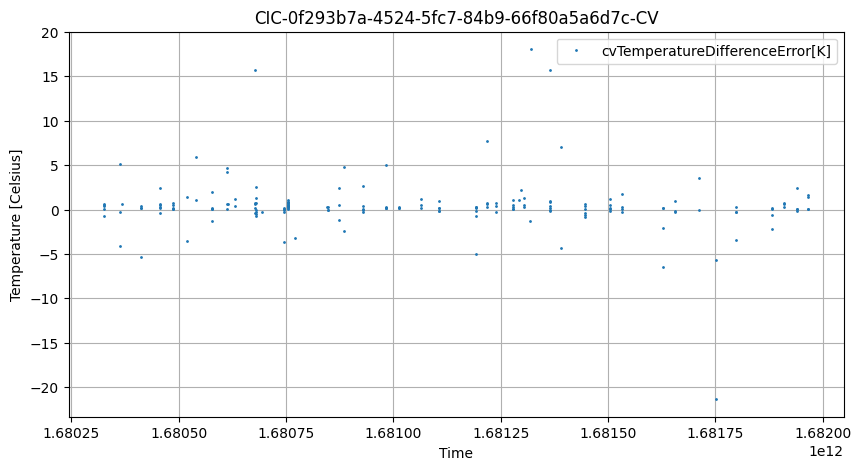

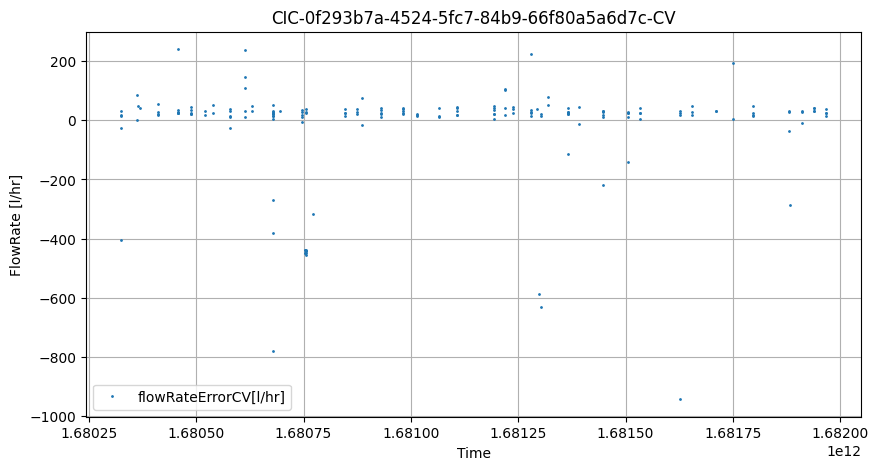

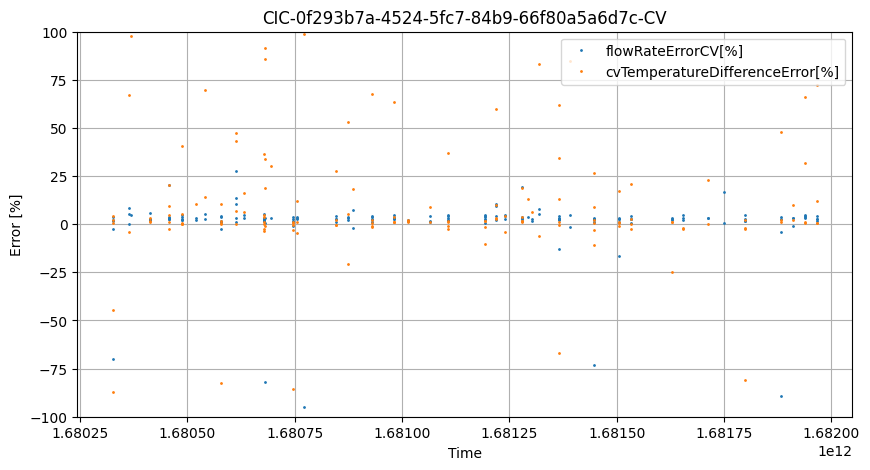

For cic:  CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6
mean flowRate error :  -inf [%]
median flowRate error :  -14.089395058139528 [%]
mean temperature difference error :  -232.9429905559762 [%]
median temperature difference error :  33.45186220092211 [%]


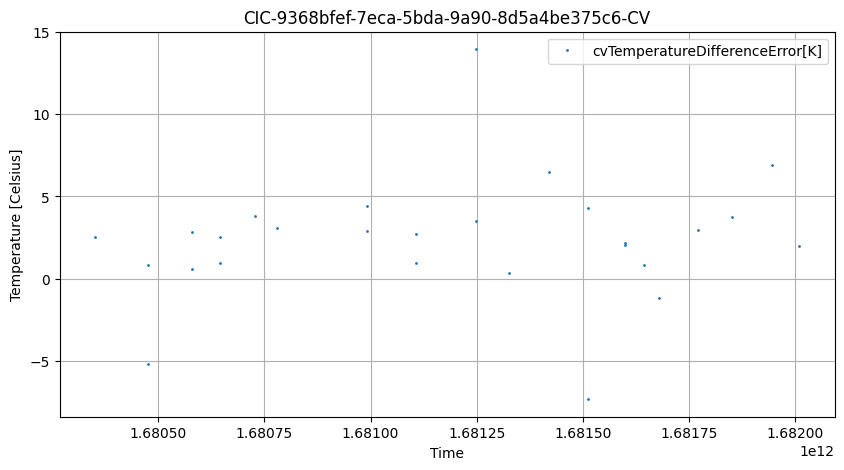

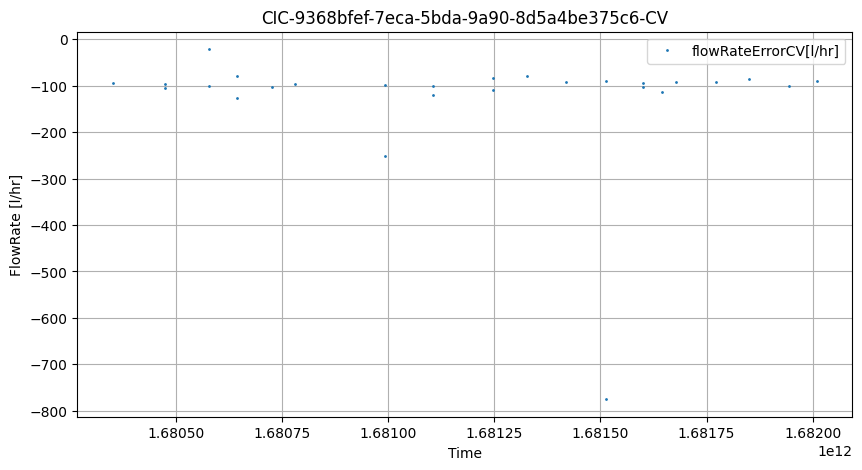

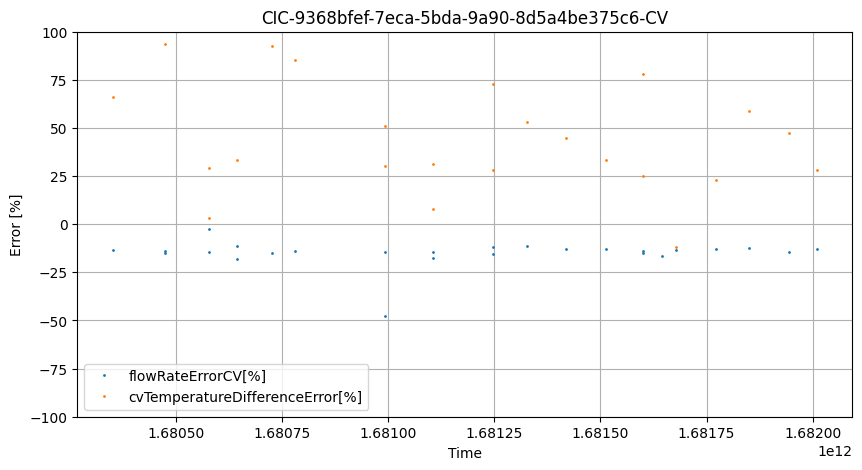

In [41]:
water_density = 997 # kg/m3
caloric_value_water = 4.186 # kJ/kgK

heat_df['flowRateErrorCV[l/hr]'] = heat_df['system.externalEnergyMeter2Flow'] - heat_df['flowMeter.flowRate']
heat_df['flowRateErrorCV[%]'] = heat_df['flowRateErrorCV[l/hr]'] / heat_df['system.externalEnergyMeter2Flow'] * 100

heat_df['cvTemperatureDifferenceInternal'] = heat_df['flowMeter.waterSupplyTemperature'] - heat_df['hp1.temperatureWaterOut']
heat_df['cvTemperatureDifferenceExternal'] = heat_df['system.externalEnergyMeter2Supply'] - heat_df['system.externalEnergyMeter2Return']
heat_df['cvTemperatureDifferenceError[K]'] = heat_df['cvTemperatureDifferenceExternal'] - heat_df['cvTemperatureDifferenceInternal']
heat_df['cvTemperatureDifferenceError[%]'] = heat_df['cvTemperatureDifferenceError[K]'] / heat_df['cvTemperatureDifferenceExternal'] * 100

for key, grp in heat_df.groupby('system.quattId'):
    print('For cic: ', key)
    print('mean flowRate error : ', grp[(grp['qc.supervisoryControlMode']==4) & 
                                        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['flowRateErrorCV[%]'].mean(), '[%]')
    print('median flowRate error : ', grp[(grp['qc.supervisoryControlMode']==4) & 
                                          (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['flowRateErrorCV[%]'].median(), '[%]')

    print('mean temperature difference error : ', grp[(grp['qc.supervisoryControlMode']==4) & 
                                                      (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['cvTemperatureDifferenceError[%]'].replace([np.inf, -np.inf], np.nan).mean(), '[%]')
    print('median temperature difference error : ', grp[(grp['qc.supervisoryControlMode']==4) & 
                                                        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['cvTemperatureDifferenceError[%]'].replace([np.inf, -np.inf], np.nan).median(), '[%]')
    
    # plot absolute temperature error
    grp[(grp['qc.supervisoryControlMode']==4) & 
        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)][['time.ts','cvTemperatureDifferenceError[K]']].plot(x='time.ts',
                                                                                                                   figsize=(10,5),
                                                                                                                   title=f'{key}-CV',
                                                                                                                   style='o',markersize=1)
    plt.ylabel('Temperature [Celsius]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

    # plot absolute flowrate error
    grp[(grp['qc.supervisoryControlMode']==4) & 
        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)][['time.ts','flowRateErrorCV[l/hr]']].plot(x='time.ts',
                                                                                                         figsize=(10,5),
                                                                                                         title=f'{key}-CV',
                                                                                                         style='o',markersize=1)
    plt.ylabel('FlowRate [l/hr]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

    # plot relative errors
    grp[(grp['qc.supervisoryControlMode']==4) & 
        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)][['time.ts','flowRateErrorCV[%]', 'cvTemperatureDifferenceError[%]']].plot(x='time.ts',
                                                                                                                                         figsize=(10,5),
                                                                                                                                         title=f'{key}-CV',
                                                                                                                                         style='o',markersize=1)
    plt.ylabel('Error [%]')
    plt.xlabel('Time')
    plt.ylim(-100,100)
    plt.grid()
    plt.show()

Then we look into the difference of the underlaying paramters (flowRate and temperature difference).  
First for __supervisoryControlMode==3__

- The negative flowRate error for one of the two heat pumps:  
    - This means that the flowRate internally estimated is higher than the externally estimated one.  
    - Could be explained by our internal flow meter measuring all the flow. Whereas the external one only measures the flow going through the boiler. It might be the case that in some of the installations (especially when when the heatpump is also on) not all the water is going through the boiler. So could be bigger for supervisorycontrolmode==3.  
- The positive temperature difference error:  
    - This means that the temperature difference measured externally is larger than internally.  
    - This could be explained by heat loss in the pipe between the heatpump out temperature and the actual temperature going into the boiler. This causes the external meter to measure a lower ingoing temperature than what the internal measurement is doing.  


For cic:  CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c
mean flowRate error :  -inf [%]
median flowRate error :  -115.679567458773 [%]
mean temperature difference error :  69.01378445515817 [%]
median temperature difference error :  82.18884011709491 [%]


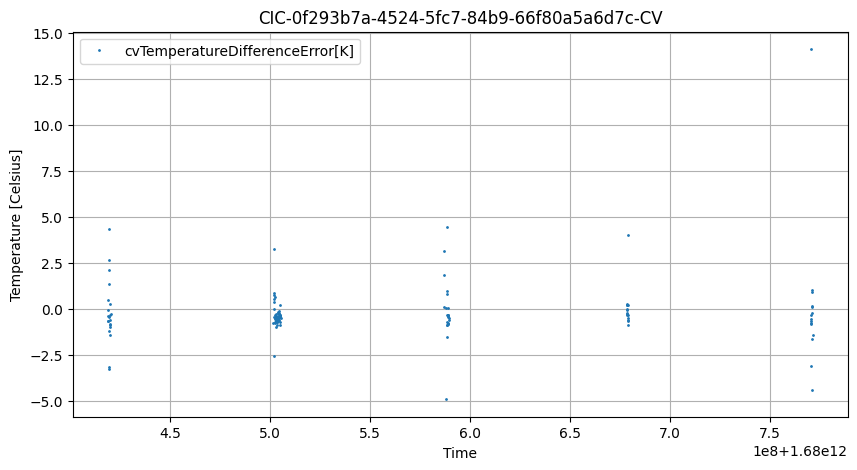

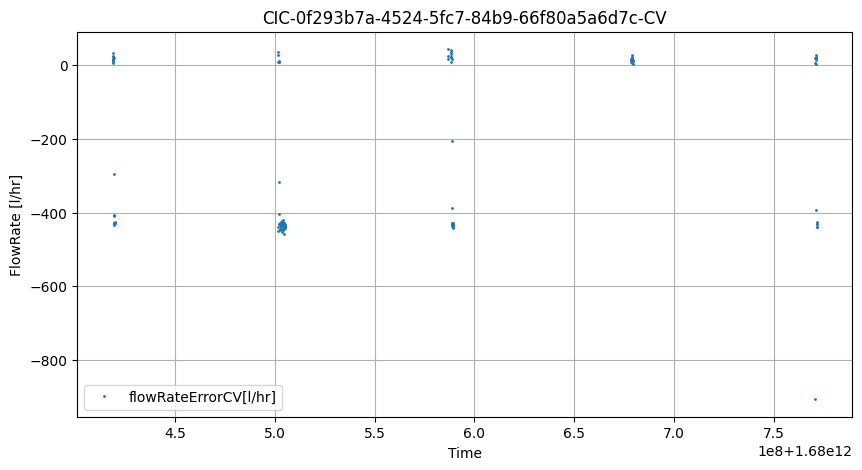

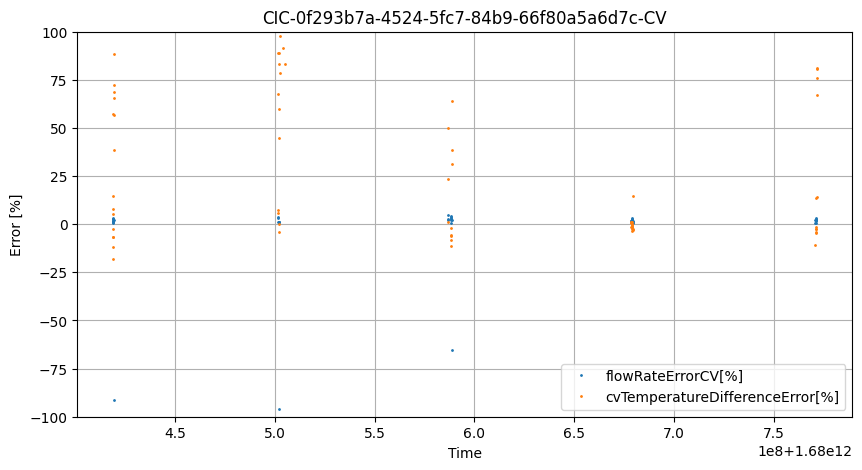

For cic:  CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6
mean flowRate error :  -inf [%]
median flowRate error :  -14.41659886845827 [%]
mean temperature difference error :  39.592202105730486 [%]
median temperature difference error :  37.78877722256682 [%]


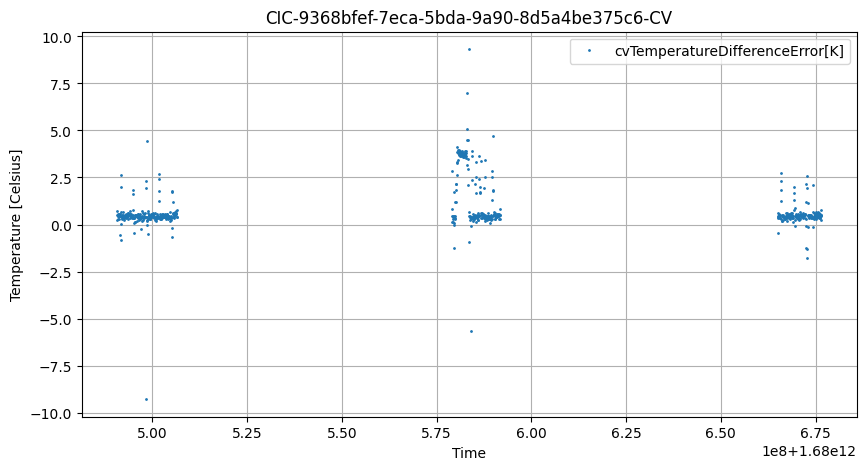

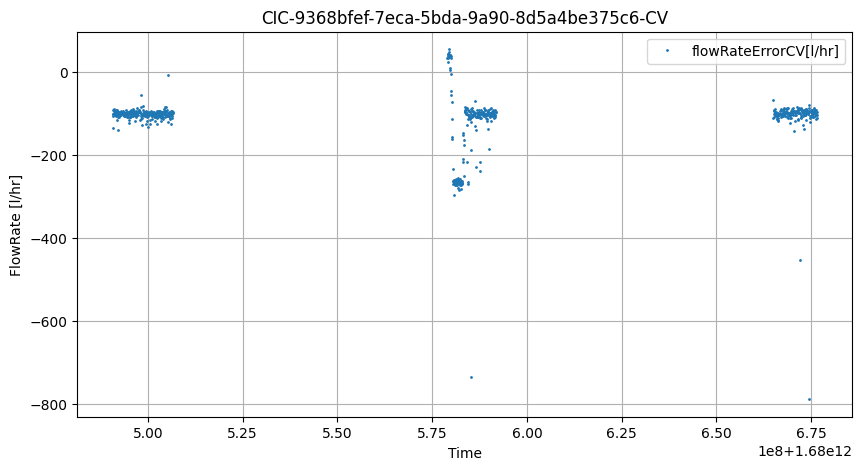

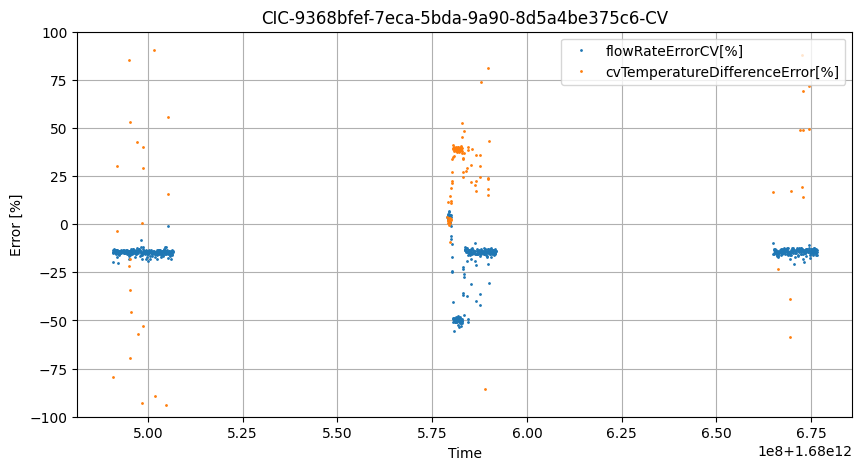

In [42]:
water_density = 997 # kg/m3
caloric_value_water = 4.186 # kJ/kgK

heat_df['flowRateErrorCV[l/hr]'] = heat_df['system.externalEnergyMeter2Flow'] - heat_df['flowMeter.flowRate']
heat_df['flowRateErrorCV[%]'] = heat_df['flowRateErrorCV[l/hr]'] / heat_df['system.externalEnergyMeter2Flow'] * 100

heat_df['cvTemperatureDifferenceInternal'] = heat_df['flowMeter.waterSupplyTemperature'] - heat_df['hp1.temperatureWaterOut']
heat_df['cvTemperatureDifferenceExternal'] = heat_df['system.externalEnergyMeter2Supply'] - heat_df['system.externalEnergyMeter2Return']
heat_df['cvTemperatureDifferenceError[K]'] = heat_df['cvTemperatureDifferenceExternal'] - heat_df['cvTemperatureDifferenceInternal']
heat_df['cvTemperatureDifferenceError[%]'] = heat_df['cvTemperatureDifferenceError[K]'] / heat_df['cvTemperatureDifferenceExternal'] * 100

for key, grp in heat_df.groupby('system.quattId'):
    print('For cic: ', key)
    print('mean flowRate error : ', grp[(grp['qc.supervisoryControlMode']==3) & 
                                        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['flowRateErrorCV[%]'].mean(), '[%]')
    print('median flowRate error : ', grp[(grp['qc.supervisoryControlMode']==3) & 
                                          (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['flowRateErrorCV[%]'].median(), '[%]')

    print('mean temperature difference error : ', grp[(grp['qc.supervisoryControlMode']==3) & 
                                                      (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['cvTemperatureDifferenceError[%]'].replace([np.inf, -np.inf], np.nan).mean(), '[%]')
    print('median temperature difference error : ', grp[(grp['qc.supervisoryControlMode']==3) & 
                                                        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)]['cvTemperatureDifferenceError[%]'].replace([np.inf, -np.inf], np.nan).median(), '[%]')
    
    # plot absolute temperature error
    grp[(grp['qc.supervisoryControlMode']==3) & 
        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)][['time.ts','cvTemperatureDifferenceError[K]']].plot(x='time.ts',
                                                                                                                   figsize=(10,5),
                                                                                                                   title=f'{key}-CV',
                                                                                                                   style='o',markersize=1)
    plt.ylabel('Temperature [Celsius]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

    # plot absolute flowrate error
    grp[(grp['qc.supervisoryControlMode']==3) & 
        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)][['time.ts','flowRateErrorCV[l/hr]']].plot(x='time.ts',
                                                                                                         figsize=(10,5),
                                                                                                         title=f'{key}-CV',
                                                                                                         style='o',markersize=1)
    plt.ylabel('FlowRate [l/hr]')
    plt.xlabel('Time')
    plt.grid()
    plt.show()

    # plot relative errors
    grp[(grp['qc.supervisoryControlMode']==3) & 
        (grp['system.externalEnergyMeter2PowerDiff'].abs()>1)][['time.ts','flowRateErrorCV[%]', 'cvTemperatureDifferenceError[%]']].plot(x='time.ts',
                                                                                                                                         figsize=(10,5),
                                                                                                                                         title=f'{key}-CV',
                                                                                                                                         style='o',markersize=1)
    plt.ylabel('Error [%]')
    plt.xlabel('Time')
    plt.ylim(-100,100)
    plt.grid()
    plt.show()

### extra cells

In [536]:
# check if cvPowerOutput is actually calculated by multiplying the difference in flowmeter.watersupplytemperature and hp1.watertemperatureoutput * flowmeter.flowrate

heat_df['cvPowerTest'] = (heat_df['flowMeter.waterSupplyTemperature']-heat_df['hp1.temperatureWaterOut']) * heat_df['flowMeter.flowRate'] /3600*997*4.186

In [537]:
heat_df[heat_df['qc.supervisoryControlMode']==4][['cvPowerTest', 'qc.cvPowerOutput']]

,cvPowerTest,qc.cvPowerOutput
43454,-736.000322,-511.644689
43455,-758.728236,-511.644689
43456,-739.188469,-516.481313
43457,-787.141946,-516.481313
43458,-130.374973,-516.481313
...,...,...
322125,-373.550925,-1770.062156
322126,-316.224056,-1770.062156
322127,-357.713327,-1247.229558
322128,-378.733668,-1247.229558


<Axes: xlabel='time.ts'>

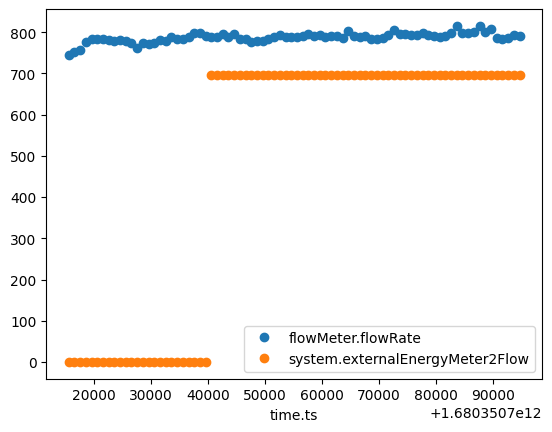

In [411]:
# CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c
# CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6


ax1 = heat_df[((heat_df['qc.supervisoryControlMode']==3) | (heat_df['qc.supervisoryControlMode']==4)) &
        (heat_df['cic_id'] == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6')][:80].plot(x='time.ts', y='flowMeter.flowRate', style='o')

heat_df[((heat_df['qc.supervisoryControlMode']==3) | (heat_df['qc.supervisoryControlMode']==4)) &
        (heat_df['cic_id'] == 'CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6')][:80].plot(x='time.ts', y='system.externalEnergyMeter2Flow', style='o', ax=ax1)

# [['time.ts', 'system.externalEnergyMeter2Flow', 'flowMeter.flowRate','qc.supervisoryControlMode']]

#### Other cells which are outdated: Check flow meter external (1) vs. flowmeter heatpump
- RQ: is our own flow meter underestimating the flowrate in comparison to the external flow meter which causes us to underestimated heat energy generated  
- H0: there's no statistical significant difference between internal and external flow meter  
- level of significance: 99.7%
- Comparing the system.externalEnergyMeter1Flow at time t, with flowMeter.flowRate at (t-X) X is still unknown  
    - only at times t where: supervisoryControlMode==2 (heatpump on), where there is a measurement of externalEnergyMeter1Flow (can roughly be done by looking at the difference of externalEnergyMeter1Flow)  
    - Has to be split on cic_id  
- using T-test 



In [11]:
for key, grp in heat_df.groupby('system.quattId'):
    print('For cic: ', key)
    print('mean flowRate error : ', grp[(grp['qc.supervisoryControlMode']==2) & 
                                        (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)]['flowRateErrorHP[l/hr]'].mean(), '[l/hr]')
    print('median flowRate error : ', grp[(grp['qc.supervisoryControlMode']==2) & 
                                          (grp['system.externalEnergyMeter1PowerDiff'].abs()>1)]['flowRateErrorHP[l/hr]'].median(), '[l/hr]')


For cic:  CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c
mean flowRate error :  40.37850250884673 [l/hr]
median flowRate error :  40.580421 [l/hr]
For cic:  CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6
mean flowRate error :  47.26498699266177 [l/hr]
median flowRate error :  47.607077000000004 [l/hr]


In [342]:
# estimate the offset in time (X) between the two meters, by minimizing the standard deviation when comparing the external measurements with internal shifted for different numbers of timestamps.

# add column to analyze rows where a new measurement has been done
heat_df['system.externalEnergyMeter1FlowDiff'] = heat_df.groupby('cic_id')['system.externalEnergyMeter1Flow'].diff()

for i in range(0,40,1):
    heat_df[f'flowMeter.flowRateShifted{i}'] = heat_df.groupby('cic_id')['flowMeter.flowRate'].shift(i)
    heat_df[f'flowMeter.flowRateDiff{i}'] = heat_df['system.externalEnergyMeter1Flow'] - heat_df[f'flowMeter.flowRateShifted{i}']
    # heat_df[f'flowMeter.flowRateDiff{i}'].fillna(0, inplace=True)
    print(f'flowMeter.flowRateDiff{i} std = ', heat_df[heat_df['qc.supervisoryControlMode']==2].groupby('cic_id')[f'flowMeter.flowRateDiff{i}'].std())

# minimum is found for i=22

flowMeter.flowRateDiff0 std =  cic_id
CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c    40.666647
CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6    46.520174
Name: flowMeter.flowRateDiff0, dtype: float64
flowMeter.flowRateDiff1 std =  cic_id
CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c    40.630607
CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6    46.522105
Name: flowMeter.flowRateDiff1, dtype: float64
flowMeter.flowRateDiff2 std =  cic_id
CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c    40.607698
CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6    46.524757
Name: flowMeter.flowRateDiff2, dtype: float64
flowMeter.flowRateDiff3 std =  cic_id
CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c    40.598529
CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6    46.527189
Name: flowMeter.flowRateDiff3, dtype: float64
flowMeter.flowRateDiff4 std =  cic_id
CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c    40.597901
CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6    46.529553
Name: flowMeter.flowRateDiff4, dtype: float64
flowMeter.flowRateDiff5 std =  cic_id
CI

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/1551529884.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  heat_df[(heat_df['time.ts']>1680325700682) &


<Axes: xlabel='time.ts'>

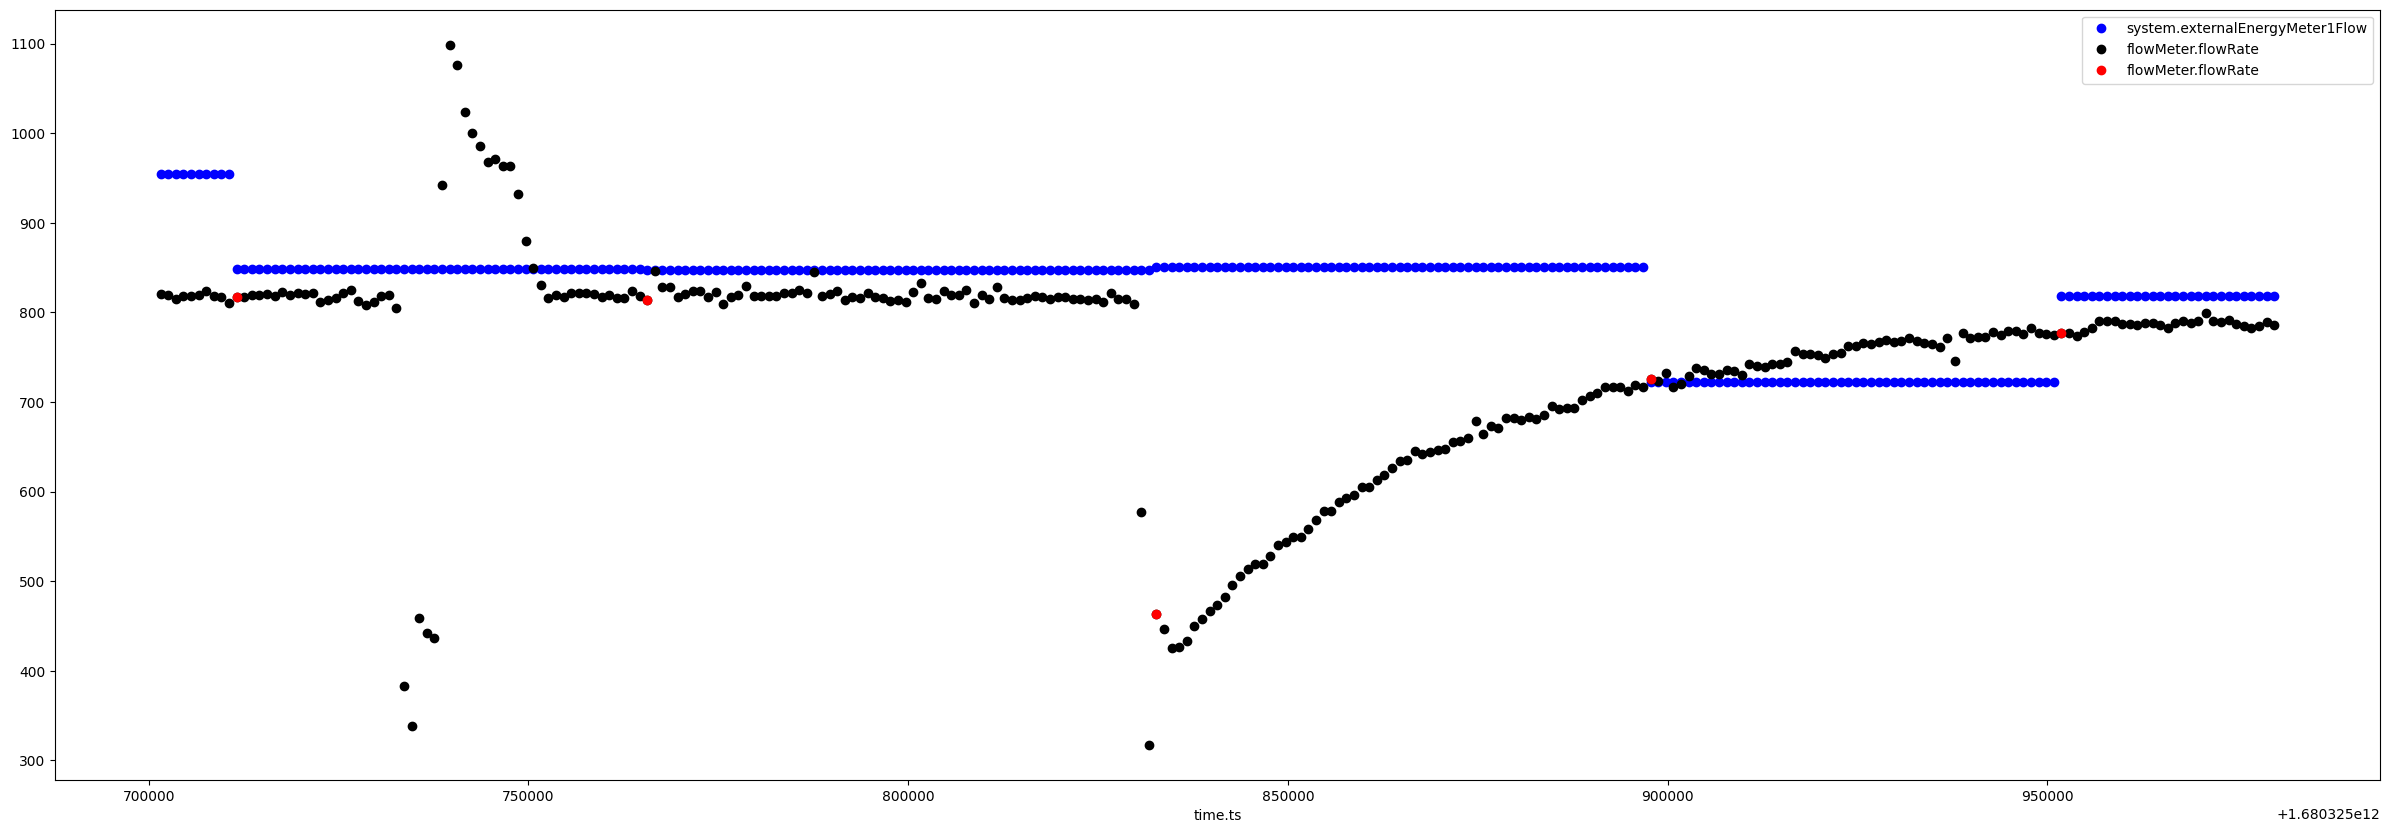

In [344]:
# visual of shifted data

ax1 = heat_df[(heat_df['time.ts']>1680325700682) & 
              (heat_df['time.ts']<1680325980682) &
              (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')].plot(x='time.ts', y='system.externalEnergyMeter1Flow', style='o', figsize=(30,10), color='blue')
heat_df[(heat_df['time.ts']>1680325700682) & 
              (heat_df['time.ts']<1680325980682) &
                (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')].plot(x='time.ts', y='flowMeter.flowRate', style='o', ax=ax1, color='black')
heat_df[(heat_df['time.ts']>1680325700682) & 
              (heat_df['time.ts']<1680325980682) &
              (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')][heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0].plot(x='time.ts', y='flowMeter.flowRate', style='o', ax=ax1, color='red')

# heat_df[(heat_df['time.ts']>1680325700682) & 
#               (heat_df['time.ts']<1680325980682) &
#                 (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')].plot(x='time.ts', y='flowMeter.flowRateShifted22', style='o', ax=ax1, color='green')
# heat_df[(heat_df['time.ts']>1680325700682) & 
#               (heat_df['time.ts']<1680325980682) &
#               (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')][heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0].plot(x='time.ts', y='flowMeter.flowRateShifted22', style='o', ax=ax1, color='cyan')


<Axes: >

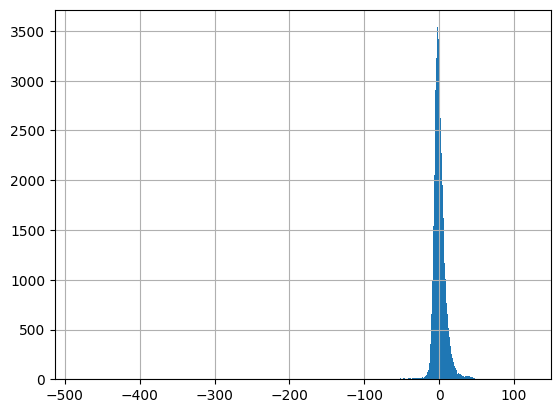

In [349]:
# The exact shift cannot be determined. So we will use the mean of 
(heat_df[heat_df['qc.supervisoryControlMode']==2]['flowMeter.flowRate'] - heat_df[heat_df['qc.supervisoryControlMode']==2]['flowMeter.flowRate'].mean()).hist(bins=1000)

In [368]:
from scipy.stats import ttest_ind

group1 = heat_df[(heat_df['qc.supervisoryControlMode']==2) & 
                 (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0) &
                 (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')]['system.externalEnergyMeter1Flow']
group2 = heat_df[(heat_df['qc.supervisoryControlMode']==2) &
                 (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0) &
                 (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')]['flowMeter.flowRateShifted22']
print('ttest for CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c: ', ttest_ind(group1, group2, equal_var=False))

group3 = heat_df[(heat_df['qc.supervisoryControlMode']==2) & 
                 (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0) &
                 (heat_df['cic_id']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6')]['system.externalEnergyMeter1Flow']
group4 = heat_df[(heat_df['qc.supervisoryControlMode']==2) &
                 (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0) &
                 (heat_df['cic_id']=='CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6')]['flowMeter.flowRateShifted5']
print('ttest for CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6: ', ttest_ind(group3, group4, equal_var=False))

ttest for CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c:  Ttest_indResult(statistic=26.651083579413065, pvalue=5.147062950882268e-114)
ttest for CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6:  Ttest_indResult(statistic=92.19525257703756, pvalue=0.0)


17       797.028552
71       802.679182
137      800.418895
191      806.104156
258      793.683930
            ...    
85996    793.791844
86050    803.540436
86116    802.349221
86171    794.971392
86237    794.504649
Name: flowMeter.flowRateShifted5, Length: 806, dtype: float64

In [205]:
# measurement error External 'class 2' 2.02% of nominal flow rate (qp (probably 0.6 m3/hr)) -> 2 + 0.2 * (qp/q) -> 2 + 0.2 * (600/800) = 2.015% -> 16.12 l/hr (@ 800 l/hr)
# measurement error Interal 1% full scale -> 50 l/m full scale -> 0.5 l/m -> 30l/hr
water_density = 997 # kg/m3
caloric_value_water = 4.186 # kJ/kgK

heat_df['flowRateErrorHP'] = heat_df['system.externalEnergyMeter1Flow'] - heat_df['flowMeter.flowRate']
heat_df['flowRateErrorCV'] = heat_df['system.externalEnergyMeter2Flow'] - heat_df['flowMeter.flowRate']

heat_df['flowRateErrorHP[%]'] = heat_df['flowRateErrorHP'] / heat_df['flowMeter.flowRate'] * 100
heat_df['flowRateErrorCV[%]'] = heat_df['flowRateErrorCV'] / heat_df['flowMeter.flowRate'] * 100

heat_df['differenceHeatPumpPower'] = heat_df['system.externalEnergyMeter1Power'] - heat_df['qc.hp1PowerOutput']
heat_df['differenceHeatPumpPower[%]'] = (heat_df['system.externalEnergyMeter1Power'] - heat_df['qc.hp1PowerOutput']) / heat_df['qc.hp1PowerOutput'] * 100

heat_df['hpTemperatureDifferenceInternal'] = heat_df['hp1.temperatureWaterOut'] - heat_df['hp1.temperatureWaterIn']
heat_df['hpTemperatureDifferenceExternal'] = heat_df['system.externalEnergyMeter1Supply'] - heat_df['system.externalEnergyMeter1Return']
heat_df['hpTemperatureDifferenceError'] = heat_df['hpTemperatureDifferenceExternal'] - heat_df['hpTemperatureDifferenceInternal']  

heat_df['system.externalEnergyMeter1PowerCalculated'] = heat_df['system.externalEnergyMeter1Flow']/3600 * caloric_value_water * water_density * heat_df['hpTemperatureDifferenceExternal']
heat_df['system.externalEnergyMeter1PowerCalculated2'] = heat_df['flowMeter.flowRate']/3600 * caloric_value_water * water_density * heat_df['hpTemperatureDifferenceExternal']
heat_df['system.externalEnergyMeter1PowerCalculated3'] = heat_df['system.externalEnergyMeter1Flow']/3600 * caloric_value_water * water_density * heat_df['hpTemperatureDifferenceInternal']



In [285]:
heat_df['system.externalEnergyMeter1FlowDiff'] = heat_df.groupby('cic_id')['system.externalEnergyMeter1Flow'].diff()
heat_df['system.externalEnergyMeter1FlowTimeDiff'] = heat_df[heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0].groupby('cic_id')['time.ts'].diff()
heat_df[heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0][['cic_id', 'time.ts', 'system.externalEnergyMeter1Flow', 'system.externalEnergyMeter1FlowDiff','system.externalEnergyMeter1FlowTimeDiff']][0:20]

,cic_id,time.ts,system.externalEnergyMeter1Flow,system.externalEnergyMeter1FlowDiff,system.externalEnergyMeter1FlowTimeDiff
17,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307215605,843.0,-18.0,NaN
71,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307269667,838.0,-5.0,54062.0
137,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307335764,850.0,12.0,66097.0
191,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307389832,851.0,1.0,54068.0
258,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307456913,839.0,-12.0,67081.0
312,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307510964,847.0,8.0,54051.0
378,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307577024,841.0,-6.0,66060.0
434,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307633101,848.0,7.0,56077.0
500,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307699178,844.0,-4.0,66077.0
554,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307753227,838.0,-6.0,54049.0


In [334]:
# try to calculate mean difference between meters, by comparing with a shifted mean, but the results are still the same
# Any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers.


for key, grp in heat_df.groupby('cic_id'):
    grp['shiftedMeans'] = grp['flowMeter.flowRate'].rolling(3).mean().shift(-5)
    grp['shiftedMeansDiff'] = grp['system.externalEnergyMeter1Flow'] - grp['shiftedMeans']
    #
    #  Computing IQR
    Q1 = grp[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)]['shiftedMeansDiff'].quantile(0.25)
    Q3 = grp[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)]['shiftedMeansDiff'].quantile(0.75)
    IQR = Q3 - Q1

    # Filtering Values between Q1-1.5IQR and Q3+1.5IQR
    print(grp[(grp['qc.supervisoryControlMode']==2) & 
              (grp['system.externalEnergyMeter1FlowDiff'].abs()>0) &
              (grp['shiftedMeansDiff'] >= Q1 - 1.5*IQR) & 
              (grp['shiftedMeansDiff'] <= Q3 + 1.5*IQR)]['shiftedMeansDiff'].describe())

count    454.000000
mean      40.935829
std        6.984327
min       23.225260
25%       36.313888
50%       41.274821
75%       45.638539
max       59.770708
Name: shiftedMeansDiff, dtype: float64
count    788.000000
mean      46.336180
std        7.439338
min       26.467344
25%       41.540561
50%       46.505909
75%       51.298745
max       66.202824
Name: shiftedMeansDiff, dtype: float64


/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/1049063854.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Q1 = grp[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)]['shiftedMeansDiff'].quantile(0.25)
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/1049063854.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Q3 = grp[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)]['shiftedMeansDiff'].quantile(0.75)
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/1049063854.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Q1 = grp[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)]['shiftedMeansDiff'].quantile(0.25)
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/1049063854.py:

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/1737641580.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  heat_df[(heat_df['time.ts']>1680325760682) &


<Axes: xlabel='time.ts'>

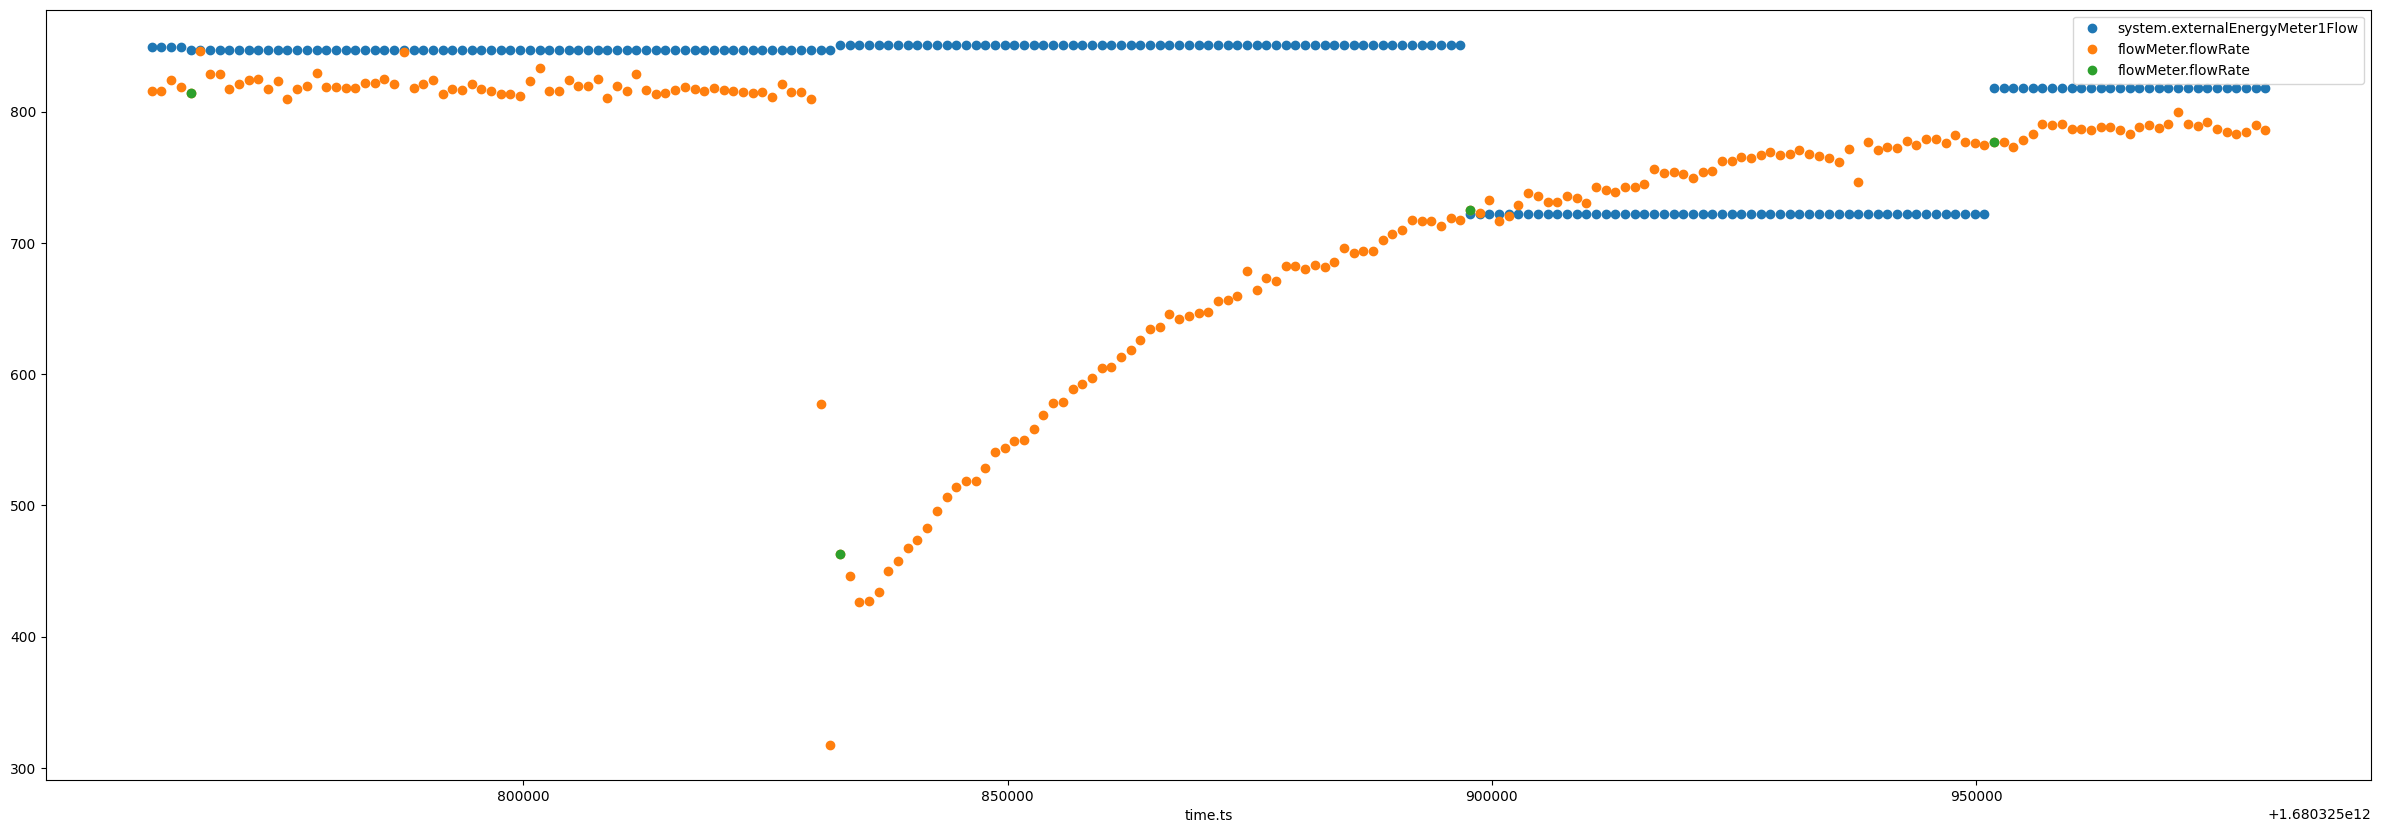

In [299]:
ax1 = heat_df[(heat_df['time.ts']>1680325760682) & 
              (heat_df['time.ts']<1680325980682) &
              (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')].plot(x='time.ts', y='system.externalEnergyMeter1Flow', style='o', figsize=(30,10))
heat_df[(heat_df['time.ts']>1680325760682) & 
              (heat_df['time.ts']<1680325980682) &
                (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')].plot(x='time.ts', y='flowMeter.flowRate', style='o', ax=ax1)
heat_df[(heat_df['time.ts']>1680325760682) & 
              (heat_df['time.ts']<1680325980682) &
              (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')][heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0].plot(x='time.ts', y='flowMeter.flowRate', style='o', ax=ax1)

In [287]:
heat_df[(heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0) &
        (heat_df['flowRateErrorHP'].abs()>80) & 
        (heat_df['qc.supervisoryControlMode']==2)]

,cic_id,time.ts,hp1.temperatureWaterIn,hp1.temperatureWaterOut,flowMeter.waterSupplyTemperature,flowMeter.flowRate,qc.supervisoryControlMode,qc.cvPowerOutput,qc.hp1PowerInput,qc.hp1PowerOutput,...,hpTemperatureDifferenceError,flowRateErrorHP[%],flowRateErrorCV[%],differenceHeatPumpPower,differenceHeatPumpPower[%],system.externalEnergyMeter1PowerCalculated,system.externalEnergyMeter1PowerCalculated2,system.externalEnergyMeter1PowerCalculated3,system.externalEnergyMeter1FlowDiff,system.externalEnergyMeter1FlowTimeDiff
5519,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680312725592,26.30,28.69,27.905500,661.701514,2.0,0.0,308.0,2186.068491,...,0.010000,28.003334,-100.000000,156.931509,7.178710,2356.603208,1841.048301,2346.784401,-3.0,55044.0
25622,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680332858049,24.36,26.65,25.915913,757.206009,2.0,0.0,308.0,2104.501603,...,0.009999,11.990659,-100.000000,225.498397,10.715050,2261.077382,2018.987477,2251.247358,4.0,65060.0
51165,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680358438327,24.59,27.12,26.324282,642.856984,2.0,0.0,288.6,2299.293650,...,-0.129998,31.911144,-100.000000,108.706350,4.727815,2359.387377,1788.618695,2487.185946,8.0,54057.0
104899,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,1680325832682,19.52,19.52,19.563903,462.958116,2.0,0.0,0.0,58.333828,...,0.299999,83.817924,82.953915,145.666172,249.711320,295.965842,161.010328,0.000000,4.0,67052.0


In [329]:
heat_df = heat_df.sort_values(by=['cic_id', 'time.ts'])
heat_df['flowMeter.flowRateShifted(10)'] = heat_df.groupby('cic_id')['flowMeter.flowRate'].shift(10)
heat_df['flowRateErrorHPShifted(10)'] = heat_df['system.externalEnergyMeter1Flow'] - heat_df['flowMeter.flowRateShifted(10)']
heat_df['flowMeter.flowRateShifted(10)rollingMean'] = heat_df.groupby('cic_id')['flowMeter.flowRateShifted(10)'].rolling(10).mean().reset_index(0, drop=True)
heat_df['flowRateErrorHPShifted(10)rollingMean'] = heat_df['system.externalEnergyMeter1Flow'] - heat_df['flowMeter.flowRateShifted(10)rollingMean']
heat_df[(heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0) &
        # (heat_df['flowRateErrorHPShifted(10)rollingMean'].abs()>80) & 
        (heat_df['qc.supervisoryControlMode']==2)].describe()

,time.ts,hp1.temperatureWaterIn,hp1.temperatureWaterOut,flowMeter.waterSupplyTemperature,flowMeter.flowRate,qc.supervisoryControlMode,qc.cvPowerOutput,qc.hp1PowerInput,qc.hp1PowerOutput,system.externalEnergyMeter1Energy,...,system.externalEnergyMeter1PowerCalculated,system.externalEnergyMeter1PowerCalculated2,system.externalEnergyMeter1PowerCalculated3,system.externalEnergyMeter1FlowDiff,system.externalEnergyMeter1FlowTimeDiff,flowMeter.flowRateShifted(+10),flowMeter.flowRateShifted(10),flowRateErrorHPShifted(10),flowMeter.flowRateShifted(10)rollingMean,flowRateErrorHPShifted(10)rollingMean
count,1.272000e+03,1272.000000,1272.000000,1272.000000,1272.000000,1272.0,1272.0,1272.000000,1272.000000,1272.00000,...,1272.000000,1272.000000,1272.000000,1272.000000,1271.000000,1272.000000,1272.000000,1272.000000,1271.000000,1271.000000
mean,1.680351e+12,26.938797,29.751926,29.219845,799.931233,2.0,0.0,424.264701,2593.369708,1255.63522,...,2719.244128,2575.602685,2755.171076,0.047170,65796.232887,801.021154,801.001072,44.094053,800.494026,44.602748
std,2.310458e+07,4.932592,5.442270,5.750195,15.838488,0.0,0.0,204.301819,648.371056,46.79571,...,689.348530,659.321073,670.465419,17.953677,19460.800743,15.629995,15.625449,11.996350,13.171259,7.176989
min,1.680307e+12,18.390000,18.390000,17.480131,462.958116,2.0,0.0,0.000000,-81.007112,1167.00000,...,-856.598607,-819.355299,0.000000,-350.000000,-14014.000000,522.601057,522.601057,-10.480910,485.763277,11.242261
25%,1.680330e+12,24.360000,26.770000,25.961510,796.281545,2.0,0.0,291.200000,2207.394085,1223.00000,...,2334.346246,2204.032604,2348.239309,-5.000000,55049.000000,796.798103,796.798103,38.538620,799.132068,39.967633
50%,1.680352e+12,25.030000,27.610000,26.767469,799.936487,2.0,0.0,312.200000,2304.925525,1251.00000,...,2451.897175,2311.492809,2453.456419,0.000000,65054.000000,800.728096,800.709437,44.371827,801.096575,44.507071
75%,1.680370e+12,28.090000,31.330000,31.248226,804.502381,2.0,0.0,442.000000,2777.449239,1293.00000,...,2932.712472,2777.351327,2953.518819,5.000000,66060.000000,805.483292,805.460523,49.535400,803.349333,48.861169
max,1.680394e+12,41.340000,45.880000,46.477032,850.313953,2.0,0.0,1137.300000,4422.125074,1347.00000,...,4788.674671,4562.781617,4750.907258,242.000000,187267.000000,858.985929,858.985929,200.953830,858.079138,81.448551


/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_61179/1850138919.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  heat_df[(heat_df['time.ts']>1680355340890) &


<Axes: xlabel='time.ts'>

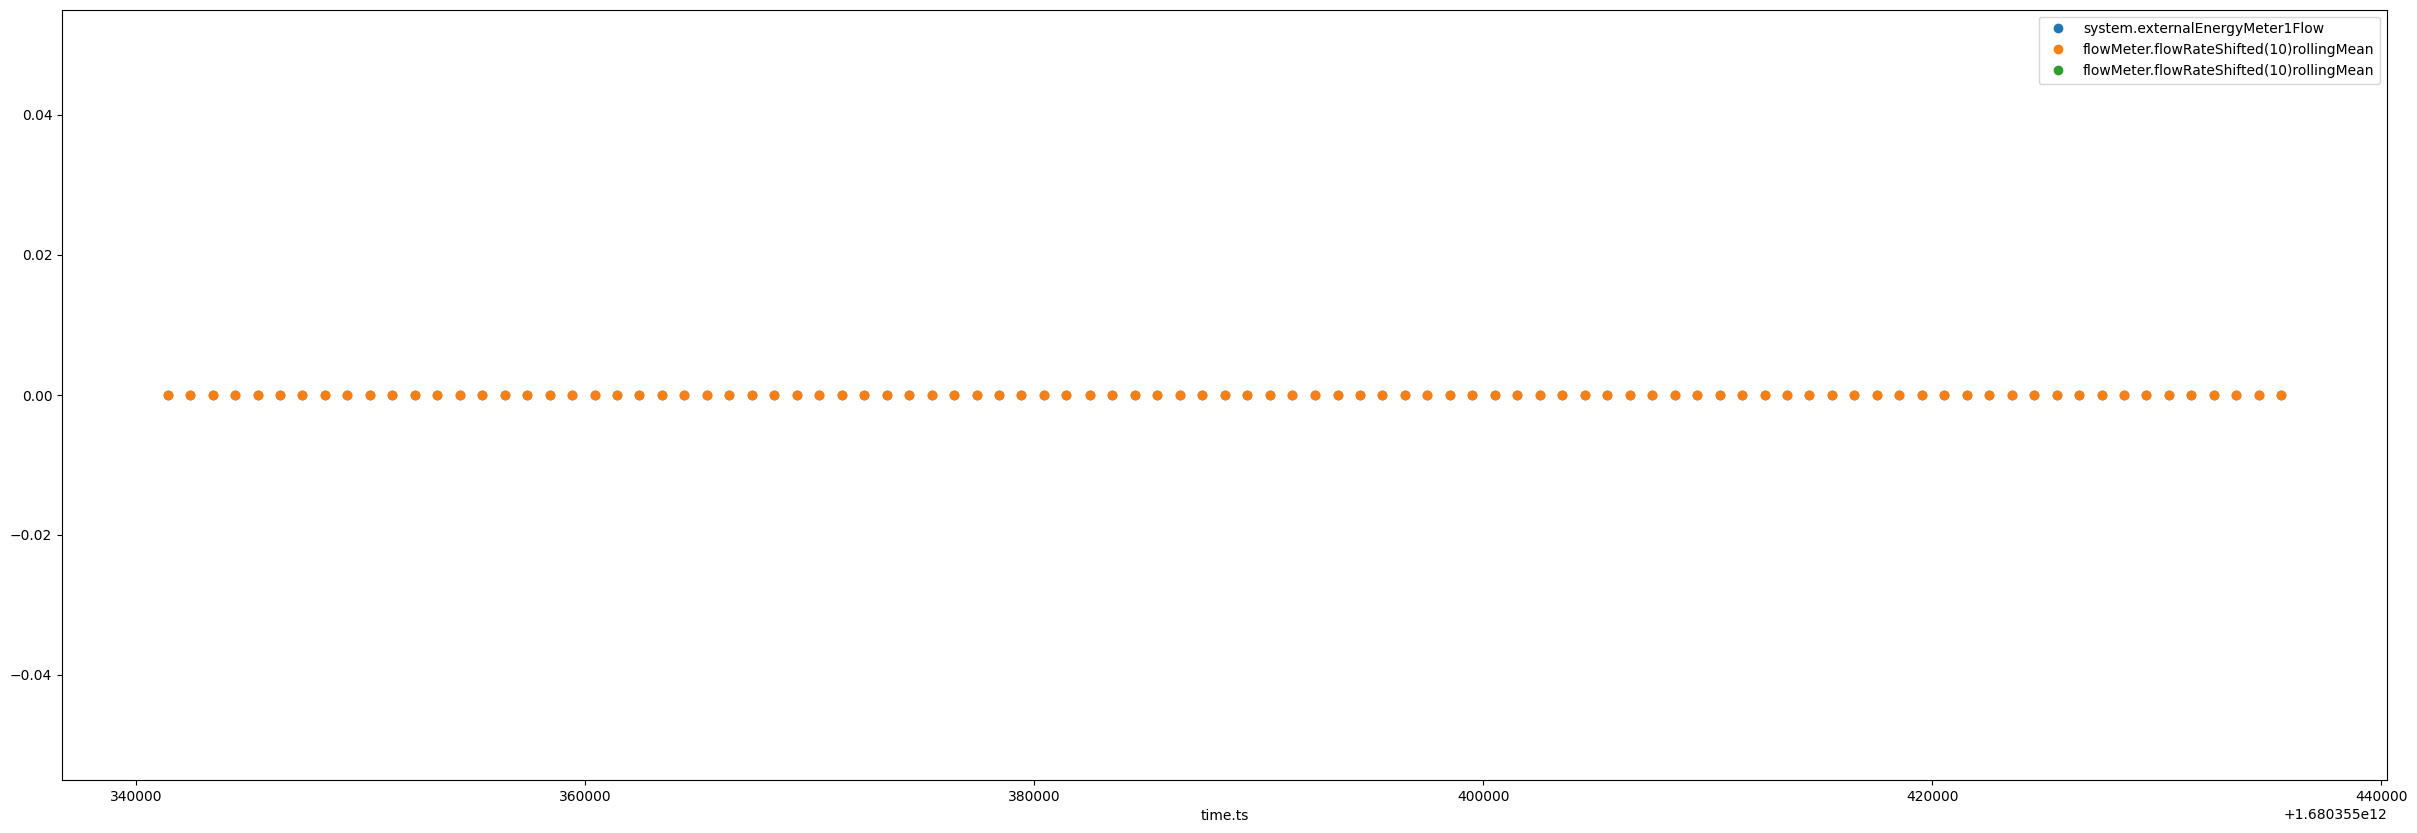

In [326]:
ax1 = heat_df[(heat_df['time.ts']>1680355340890) & 
              (heat_df['time.ts']<1680355435890) &
              (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')].plot(x='time.ts', y='system.externalEnergyMeter1Flow', style='o', figsize=(30,10))
heat_df[(heat_df['time.ts']>1680355340890) & 
              (heat_df['time.ts']<1680355435890) &
                (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')].plot(x='time.ts', y='flowMeter.flowRateShifted(10)rollingMean', style='o', ax=ax1)
heat_df[(heat_df['time.ts']>1680355340890) & 
              (heat_df['time.ts']<1680355435890) &
              (heat_df['cic_id']=='CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c')][heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0].plot(x='time.ts', y='flowMeter.flowRateShifted(10)rollingMean', style='o', ax=ax1)

In [257]:
heat_df[heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0]['system.externalEnergyMeter1FlowDiff'].describe()

count    1359.000000
mean       -0.304636
std        90.630681
min      -849.000000
25%        -5.000000
50%        -1.000000
75%         5.000000
max       817.000000
Name: system.externalEnergyMeter1FlowDiff, dtype: float64

In [254]:
heat_df[heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0].groupby('cic_id')['time.ts'].diff().describe()

count    1.357000e+03
mean     1.272612e+05
std      8.703703e+05
min     -1.401400e+04
25%      5.504900e+04
50%      6.505600e+04
75%      6.606100e+04
max      1.809183e+07
Name: time.ts, dtype: float64

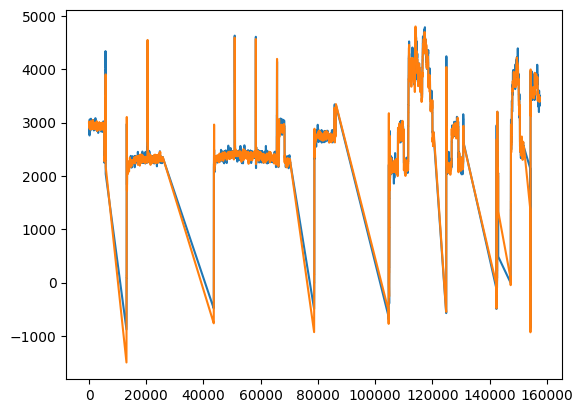

In [197]:
heat_df[heat_df['qc.supervisoryControlMode']==2]['system.externalEnergyMeter1PowerCalculated'].plot()
heat_df[heat_df['qc.supervisoryControlMode']==2]['system.externalEnergyMeter1Power'].plot()
plt.show()

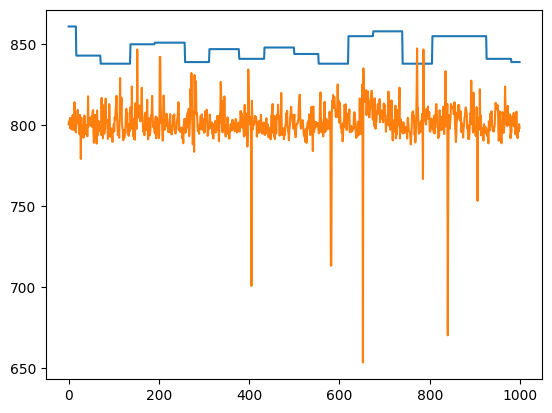

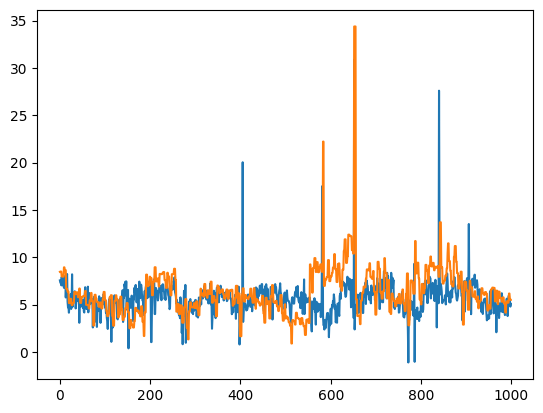

In [193]:
heat_df['system.externalEnergyMeter1Flow'][:1000].plot()
heat_df['flowMeter.flowRate'][:1000].plot()
plt.show()

heat_df[heat_df['qc.supervisoryControlMode']==2]['flowRateErrorHP[%]'][:1000].plot()
heat_df[heat_df['qc.supervisoryControlMode']==2]['differenceHeatPumpPower[%]'][:1000].plot()
plt.show()

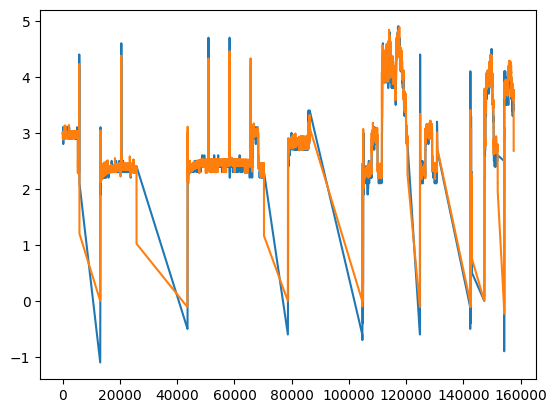

In [176]:

heat_df[heat_df['qc.supervisoryControlMode']==2]['hpTemperatureDifferenceExternal'].plot()
heat_df[heat_df['qc.supervisoryControlMode']==2]['hpTemperatureDifferenceInternal'].plot()
plt.show()



In [288]:
heat_df[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)].groupby('cic_id')['flowRateErrorHP[%]'].describe()

,count,mean,std,min,25%,50%,75%,max
cic_id,,,,,,,,
CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,464.0,5.225107,3.859760,-8.589763,4.536258,5.116570,5.756183,83.817924
CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,808.0,5.944396,1.624118,0.198285,5.280541,5.962807,6.534857,31.911144


In [201]:
heat_df[heat_df['qc.supervisoryControlMode']==2]['hpTemperatureDifferenceError'].describe()

count    83559.000000
mean        -0.051795
std          0.256554
min         -3.920000
25%         -0.120000
50%         -0.030000
75%          0.020000
max          4.100000
Name: hpTemperatureDifferenceError, dtype: float64

In [203]:
heat_df[heat_df['qc.supervisoryControlMode']==2]['system.externalEnergyMeter1Return'].describe()

count    83559.000000
mean        27.652246
std          4.941966
min         18.100000
25%         25.100000
50%         25.799999
75%         28.700001
max         42.400002
Name: system.externalEnergyMeter1Return, dtype: float64

In [246]:
heat_df[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)]['differenceHeatPumpPower'].describe()

count    1272.000000
mean      110.601990
std       167.227607
min     -1087.365691
25%        52.066651
50%       109.759536
75%       169.269650
max      2254.000000
Name: differenceHeatPumpPower, dtype: float64

In [208]:
(heat_df['system.externalEnergyMeter1PowerCalculated'] - heat_df['qc.hp1PowerOutput'])[heat_df['qc.supervisoryControlMode']==2].describe()

count    83559.000000
mean       113.755181
std        248.880020
min      -3517.959237
25%         43.240332
50%        114.583060
75%        184.004966
max       4044.875295
dtype: float64

KeyError: 'flowRateErrorHP'

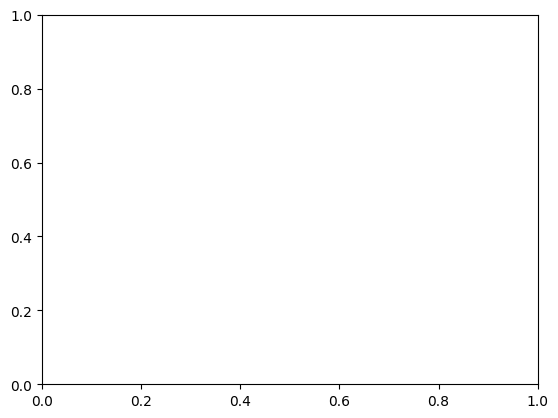

In [386]:
heat_df[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)].groupby('system.quattId').plot(x='flowMeter.flowRate', y='flowRateErrorHP', kind='scatter')

system.quattId
CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c    Axes(0.125,0.11;0.775x0.77)
CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6    Axes(0.125,0.11;0.775x0.77)
dtype: object

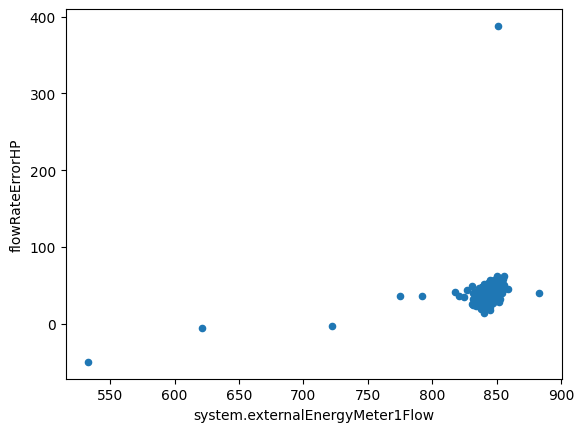

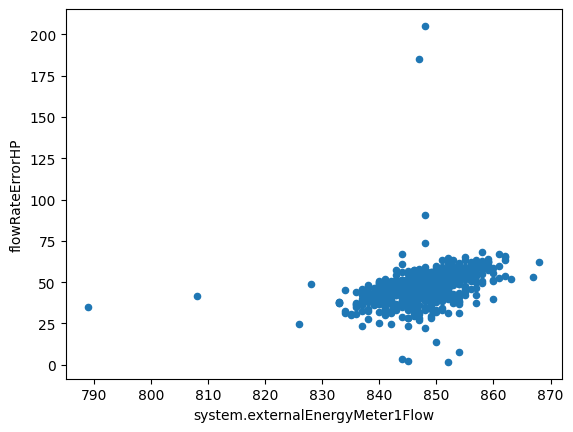

In [242]:
heat_df[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)].groupby('system.quattId').plot(x='system.externalEnergyMeter1Flow', y='flowRateErrorHP', kind='scatter')

(600.0, 900.0)

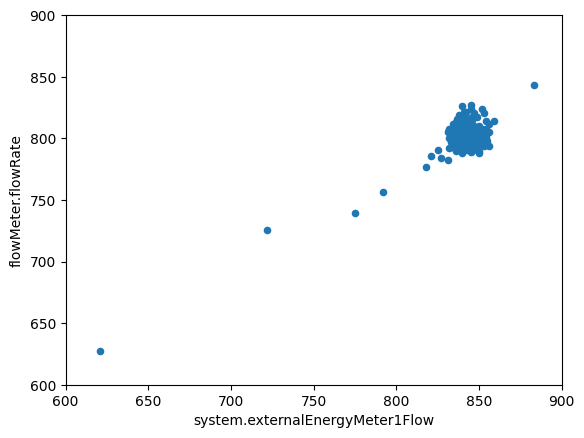

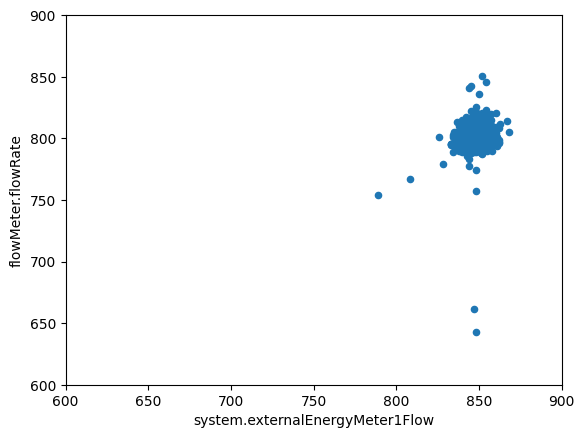

In [241]:
ax1, ax2 = heat_df[(heat_df['qc.supervisoryControlMode']==2) & (heat_df['system.externalEnergyMeter1FlowDiff'].abs()>0)].groupby('system.quattId').plot(y='flowMeter.flowRate', x='system.externalEnergyMeter1Flow', kind='scatter')

ax1.set_xlim([600, 900])
ax1.set_ylim([600, 900])
ax2.set_xlim([600, 900])
ax2.set_ylim([600, 900])

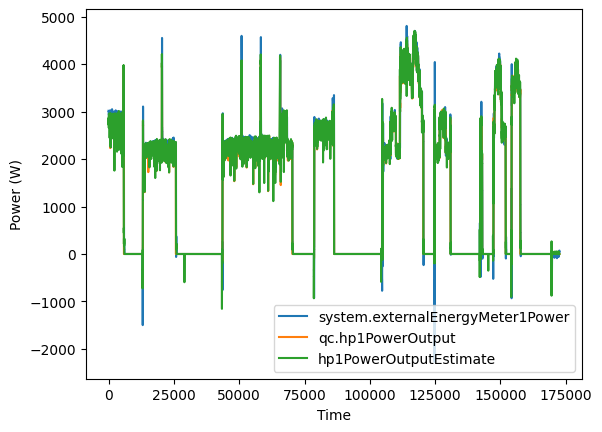

In [142]:


heat_df['temperatureDifference'] = heat_df['hp1.temperatureWaterOut'] - heat_df['hp1.temperatureWaterIn']
heat_df['hp1PowerOutputEstimate'] = heat_df['flowMeter.flowRate']/3600 * caloric_value_water * water_density * heat_df['temperatureDifference']

heat_df['system.externalEnergyMeter1Power'].plot()
heat_df['qc.hp1PowerOutput'].plot()
heat_df['hp1PowerOutputEstimate'].plot()
plt.ylabel('Power (W)')
plt.xlabel('Time')
plt.legend()
plt.show()

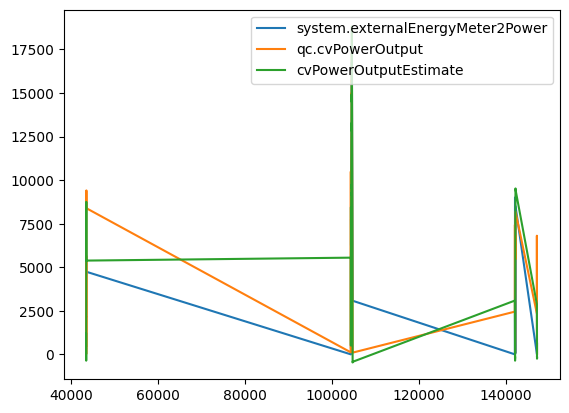

In [57]:
heat_df['cvTemperatureDifference'] = heat_df['flowMeter.waterSupplyTemperature'] - heat_df['hp1.temperatureWaterOut']
heat_df['cvPowerOutputEstimate'] = heat_df['flowMeter.flowRate']/3600 * caloric_value_water * water_density * heat_df['cvTemperatureDifference']

heat_df[heat_df['qc.cvPowerOutput']>0]['system.externalEnergyMeter2Power'].plot()
heat_df[heat_df['qc.cvPowerOutput']>0]['qc.cvPowerOutput'].plot()
heat_df[heat_df['qc.cvPowerOutput']>0]['cvPowerOutputEstimate'].plot()
plt.legend()
plt.show()

In [54]:
heat_df

,cic_id,time.ts,hp1.temperatureWaterIn,hp1.temperatureWaterOut,flowMeter.waterSupplyTemperature,flowMeter.flowRate,qc.cvPowerOutput,qc.hp1PowerInput,qc.hp1PowerOutput,system.quattId,...,predictedEnergyCV,totalPredictedEnergyCV,measuredEnergyCV,totalMeasuredEnergyCV,totalMeterEnergyCV,temperatureDifference,hp1PowerOutputEstimate1,hp1PowerOutputEstimate,cvTemperatureDifference,cvPowerOutputEstimate
0,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307198576,26.42,29.43,28.704682,800.498424,0.0,438.0,2780.725813,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,...,NaN,NaN,NaN,NaN,0.0,3.01,2801.713354,2793.308213,-0.725318,-673.102287
1,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307199577,26.42,29.43,28.551511,802.263935,0.0,438.0,2780.029696,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,...,0.0,0.000000,0.0,0.000000,0.0,3.01,2807.892573,2799.468896,-0.878489,-817.044463
2,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307200578,26.42,29.43,28.689047,802.458549,0.0,438.0,2780.029696,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,...,0.0,0.000000,0.0,0.000000,0.0,3.01,2808.573715,2800.147994,-0.740953,-689.294575
3,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307201579,26.42,29.43,28.601515,804.333036,0.0,438.0,2780.029696,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,...,0.0,0.000000,0.0,0.000000,0.0,3.01,2815.134346,2806.688943,-0.828485,-772.524771
4,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,1680307202580,26.42,29.43,28.676541,797.897178,0.0,438.0,2793.346818,CIC-9368bfef-7eca-5bda-9a90-8d5a4be375c6,...,0.0,0.000000,0.0,0.000000,0.0,3.01,2792.609094,2784.231266,-0.753459,-696.944940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172586,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,1680393585198,16.18,16.18,15.705225,428.038190,0.0,0.0,0.000000,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,...,0.0,3.098769,0.0,3.896109,5.0,0.00,0.000000,0.000000,-0.474775,-235.593170
172587,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,1680393586199,16.18,16.18,15.717049,420.784447,0.0,0.0,0.000000,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,...,0.0,3.098769,0.0,3.896109,5.0,0.00,0.000000,0.000000,-0.462951,-225.832423
172588,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,1680393587200,16.18,16.18,15.728875,429.732814,0.0,0.0,0.000000,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,...,0.0,3.098769,0.0,3.896109,5.0,0.00,0.000000,0.000000,-0.451125,-224.743699
172589,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,1680393588201,16.18,16.18,15.640199,424.590103,0.0,0.0,0.000000,CIC-0f293b7a-4524-5fc7-84b9-66f80a5a6d7c,...,0.0,3.098769,0.0,3.896109,5.0,0.00,0.000000,0.000000,-0.539801,-265.702133


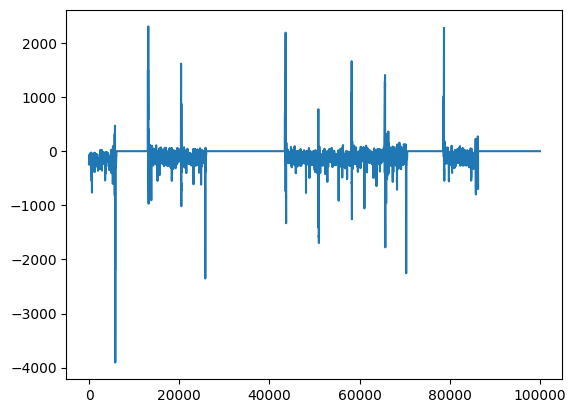

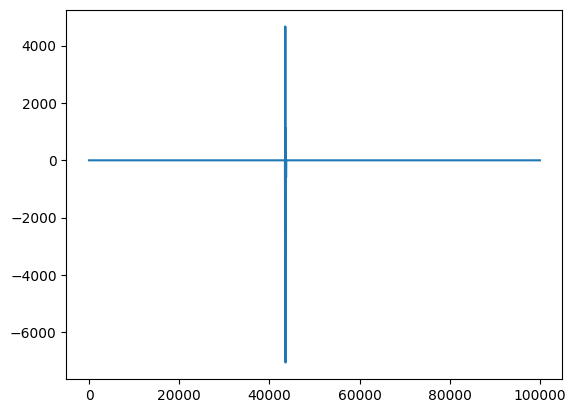

In [12]:
heat_df['differenceHeatPumpPower'] = heat_df['qc.hp1PowerOutput'] - heat_df['system.externalEnergyMeter1Power']
heat_df['differenceCvPower'] = heat_df['qc.cvPowerOutput'] - heat_df['system.externalEnergyMeter2Power']
heat_df['differenceHeatPumpPower'][:100000].plot()
plt.show()
heat_df['differenceCvPower'][:100000].plot()
plt.show()

In [13]:
heat_df[heat_df['differenceHeatPumpPower']!=0]['differenceHeatPumpPower'].describe()

count    89192.000000
mean      -107.367070
std        307.513672
min      -3904.000000
25%       -168.310627
50%       -105.524427
75%        -33.943979
max       3593.360630
Name: differenceHeatPumpPower, dtype: float64

/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_97108/3447385477.py:12: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  heat_df['totalMeterEnergyHP'] = heat_df.groupby('system.quattId', sort='time.ts')['system.externalEnergyMeter1Energy'].apply(lambda x: x - x.iloc[0])
/var/folders/0m/6_0b79q57177vdz5tjzlnt1w0000gn/T/ipykernel_97108/3447385477.py:19: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_

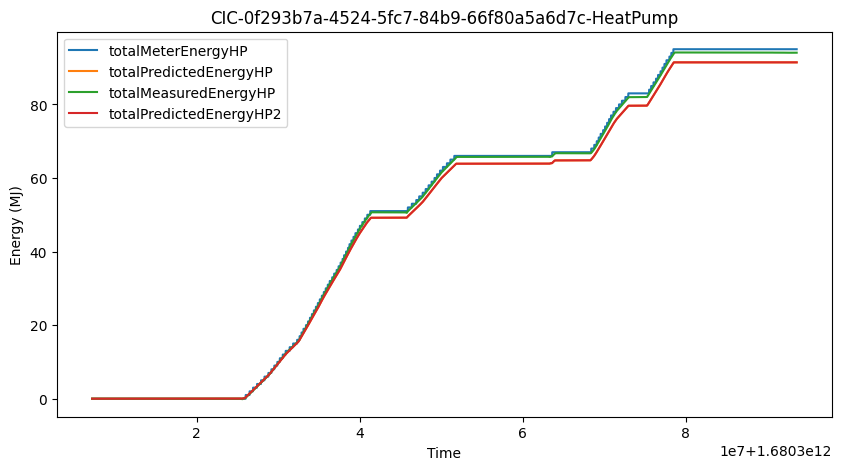

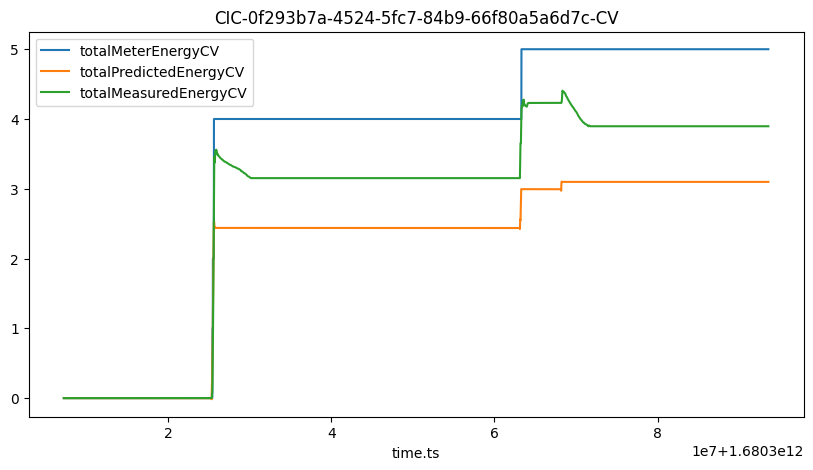

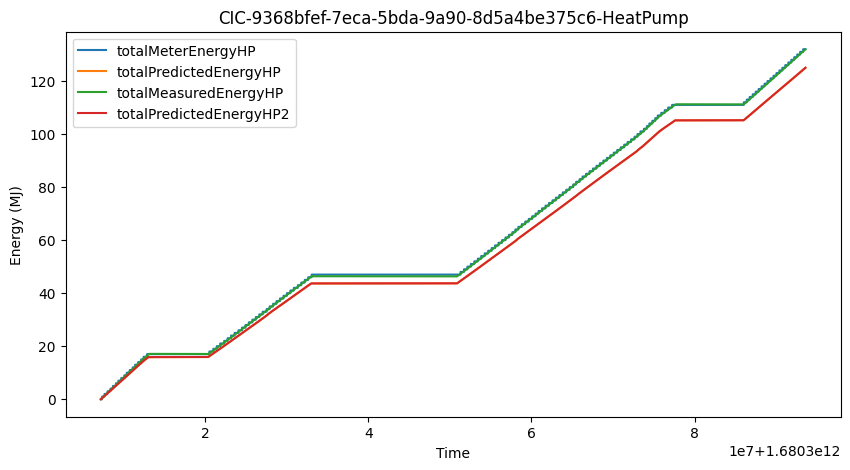

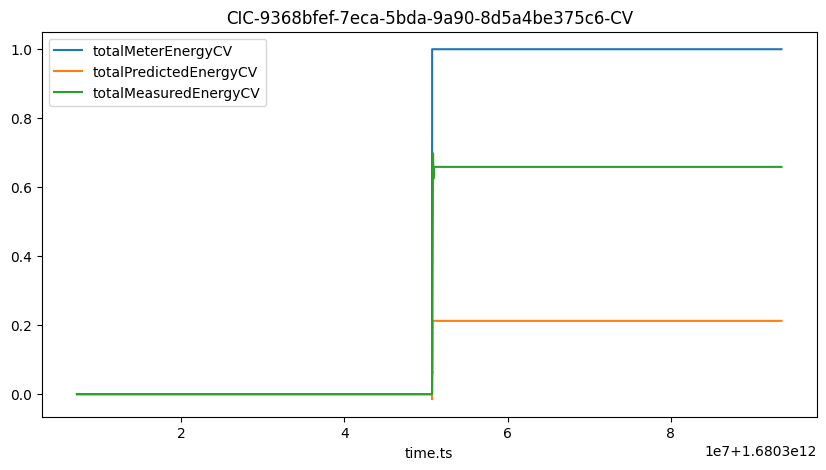

In [61]:
# unit of Heat Energy looks like its MJ
# convert powers to energy
heat_df['timeDelta[S]'] = heat_df.groupby('system.quattId', sort='time.ts')['time.ts'].diff()/1000

# heat pump energies
heat_df['predictedEnergyHP'] = (heat_df['qc.hp1PowerOutput'] * heat_df['timeDelta[S]']) / 1000000
heat_df['totalPredictedEnergyHP'] = heat_df.groupby('system.quattId', sort='time.ts')['predictedEnergyHP'].cumsum()
heat_df['predictedEnergyHP2'] = (heat_df['hp1PowerOutputEstimate'] * heat_df['timeDelta[S]']) / 1000000
heat_df['totalPredictedEnergyHP2'] = heat_df.groupby('system.quattId', sort='time.ts')['predictedEnergyHP'].cumsum()
heat_df['measuredEnergyHP'] = (heat_df['system.externalEnergyMeter1Power'] * heat_df['timeDelta[S]']) / 1000000
heat_df['totalMeasuredEnergyHP'] = heat_df.groupby('system.quattId', sort='time.ts')['measuredEnergyHP'].cumsum()
heat_df['totalMeterEnergyHP'] = heat_df.groupby('system.quattId', sort='time.ts')['system.externalEnergyMeter1Energy'].apply(lambda x: x - x.iloc[0])

# cv Energies
heat_df['predictedEnergyCV'] = (heat_df['qc.cvPowerOutput'] * heat_df['timeDelta[S]']) / 1000000
heat_df['totalPredictedEnergyCV'] = heat_df.groupby('system.quattId', sort='time.ts')['predictedEnergyCV'].cumsum()
heat_df['measuredEnergyCV'] = (heat_df['system.externalEnergyMeter2Power'] * heat_df['timeDelta[S]']) / 1000000
heat_df['totalMeasuredEnergyCV'] = heat_df.groupby('system.quattId', sort='time.ts')['measuredEnergyCV'].cumsum()
heat_df['totalMeterEnergyCV'] = heat_df.groupby('system.quattId', sort='time.ts')['system.externalEnergyMeter2Energy'].apply(lambda x: x - x.iloc[0])

# plot energy
for key, grp in heat_df.groupby('system.quattId'):
    grp[['time.ts','totalMeterEnergyHP','totalPredictedEnergyHP','totalMeasuredEnergyHP','totalPredictedEnergyHP2']].plot(x='time.ts', figsize=(10,5), 
                                                                                                         title=f'{key}-HeatPump')
    plt.ylabel('Energy (MJ)')
    plt.xlabel('Time')
    plt.show()
    grp[['time.ts','totalMeterEnergyCV','totalPredictedEnergyCV','totalMeasuredEnergyCV']].plot(x='time.ts', figsize=(10,5), 
                                                                                                         title=f'{key}-CV')
    plt.show()